In [1]:
!git clone https://github.com/sheikhtajamul38/Adversarial-Collaborative-Filtering---RecSys.git

Cloning into 'Adversarial-Collaborative-Filtering---RecSys'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 79 (delta 17), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (79/79), 17.62 MiB | 4.78 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [17]:
import os
import time
import argparse
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

In [2]:
dataset = 'ml-1m'

main_path = '/content/Adversarial-Collaborative-Filtering---RecSys/Data/'

train_rating = main_path + '{}.train.rating'.format(dataset)
test_rating = main_path + '{}.test.rating'.format(dataset)
test_negative = main_path + '{}.test.negative'.format(dataset)

model_path = './models/'
BPR_model_path = model_path + 'BPR.pth'

In [13]:
def load_rating_file_as_list(filename):
    ratingList = []
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            user, item = int(arr[0]), int(arr[1])
            ratingList.append([user, item])
            line = f.readline()
    return ratingList

def load_all(train_file, test_file):
    train_data = pd.read_csv(train_file, sep='\t', header=None, names=['user', 'item'], usecols=[0, 1], dtype={0: np.int32, 1: np.int32})

    user_num = train_data['user'].max() + 1
    item_num = train_data['item'].max() + 1

    train_data = train_data.values.tolist()
    test_data = load_rating_file_as_list(test_file)
    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for x in train_data:
        train_mat[x[0], x[1]] = 1.0

    return train_data, test_data, user_num, item_num, train_mat

In [12]:
# def load_all(test_num=100):
# 	""" We load all the three file here to save time in each epoch. """
# 	train_data = pd.read_csv(
# 		train_rating,
# 		sep='\t', header=None, names=['user', 'item'],
# 		usecols=[0, 1], dtype={0: np.int32, 1: np.int32})

# 	user_num = train_data['user'].max() + 1
# 	item_num = train_data['item'].max() + 1

# 	train_data = train_data.values.tolist()

# 	# load ratings as a dok matrix
# 	train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
# 	for x in train_data:
# 		train_mat[x[0], x[1]] = 1.0

# 	test_data = []
# 	with open(test_negative, 'r') as fd:
# 		line = fd.readline()
# 		while line != None and line != '':
# 			arr = line.split('\t')
# 			u = eval(arr[0])[0]
# 			test_data.append([u, eval(arr[0])[1]])
# 			for i in arr[1:]:
# 				test_data.append([u, int(i)])
# 			line = fd.readline()
# 	return train_data, test_data, user_num, item_num, train_mat

In [10]:
class BPRData(data.Dataset):
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(BPRData, self).__init__()
        self.features = features
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training

        # Initialize features_fill
        self.features_fill = []

    def ng_sample(self):
        assert self.is_training, 'no need to sampling when testing'

        self.features_fill = []
        for x in self.features:
            u, i = x[0], x[1]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_fill.append([u, i, j])

    def __len__(self):
        return self.num_ng * len(self.features) if self.is_training else len(self.features)

    def __getitem__(self, idx):
        features = self.features_fill if self.is_training else self.features
        user = features[idx][0]
        item_i = features[idx][1]
        item_j = features[idx][2] if self.is_training else features[idx][1]
        return idx, user, item_i, item_j


In [4]:
class BPR(nn.Module):
	def __init__(self, user_num, item_num, factor_num):
		super(BPR, self).__init__()
		"""
		user_num: number of users;
		item_num: number of items;
		factor_num: number of predictive factors.
		"""
		self.embed_user = nn.Embedding(user_num, factor_num)
		self.embed_item = nn.Embedding(item_num, factor_num)

		nn.init.normal_(self.embed_user.weight, std=0.01)
		nn.init.normal_(self.embed_item.weight, std=0.01)

	def forward(self, user, item_i, item_j):
		user = self.embed_user(user)
		item_i = self.embed_item(item_i)
		item_j = self.embed_item(item_j)

		prediction_i = (user * item_i).sum(dim=-1)
		prediction_j = (user * item_j).sum(dim=-1)
		return prediction_i, prediction_j

In [ ]:
# Metrics
def hit(gt_item, pred_items):
    if gt_item in pred_items:
        return 1
    return 0

def ndcg(gt_item, pred_items):
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index+2))
    return 0

def metrics(model, test_loader, top_k, device):
    HR, NDCG = [], []

    for _, user, item_i, _ in test_loader:
        user = user.to(device)
        item_i = item_i.to(device)

        prediction_i = model(user, item_i, item_i)[0]  # The second item_i is just a placeholder
        _, indices = torch.topk(prediction_i, top_k)
        recommends = torch.take(item_i, indices).cpu().numpy().tolist()

        gt_item = item_i[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

    return np.mean(HR), np.mean(NDCG)

In [5]:
def set_args():
    args = argparse.Namespace()
    args.lr = 0.01
    args.lamda = 0.001
    args.batch_size = 4096
    args.epochs = 200
    args.top_k = 10
    args.factor_num = 128
    args.num_ng = 1
    args.test_num_ng = 99
    args.out = False

    return args

args = set_args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [7]:
# For the negative sample test
# train_data, test_data, user_num ,item_num, train_mat = load_all()

# # construct the train and test datasets
# train_dataset = BPRData(train_data, item_num, train_mat, args.num_ng, True)
# test_dataset = BPRData(test_data, item_num, train_mat, 0, False)
# train_loader = data.DataLoader(train_dataset,batch_size=args.batch_size, shuffle=True, num_workers=2)
# test_loader = data.DataLoader(test_dataset,batch_size=args.test_num_ng+1, shuffle=False, num_workers=0)


In [14]:
# For the leave one out test
train_data, test_data, user_num, item_num, train_mat = load_all(train_rating, test_rating)
train_dataset = BPRData(train_data, item_num, train_mat, args.num_ng, is_training=True)
test_dataset = BPRData(test_data, item_num, train_mat, 0, is_training=False)
train_loader = data.DataLoader(train_dataset,batch_size=args.batch_size, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_dataset,batch_size=args.test_num_ng+1, shuffle=False, num_workers=0)


In [15]:
########################### CREATE MODEL #################################
model = BPR(user_num, item_num, args.factor_num).to(device)

optimizer = optim.SGD(
			model.parameters(), lr=args.lr, weight_decay=args.lamda)
########################### TRAINING #####################################
count, best_recall = 0, 0
bpr_recall_history = []
bpr_ndcg_history = []

for epoch in range(args.epochs):
    model.train()
    start_time = time.time()
    train_loader.dataset.ng_sample()

    for batch_data in train_loader:
        _, user, item_i, item_j = batch_data
        user = user.to(device)
        item_i = item_i.to(device)
        item_j = item_j.to(device)

        model.zero_grad()
        prediction_i, prediction_j = model(user, item_i, item_j)
        loss = - (prediction_i - prediction_j).sigmoid().log().sum() #BPR Loss
        loss.backward()
        optimizer.step()
        count += 1

    model.eval()
    Recall, NDCG = metrics(model, test_loader, args.top_k, device)

    bpr_recall_history.append(Recall)
    bpr_ndcg_history.append(NDCG)


    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
        time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Recall: {:.3f}\tNDCG: {:.3f}".format(np.mean(Recall), np.mean(NDCG)))

    if Recall > best_recall:
      best_recall, best_ndcg, best_epoch = Recall, NDCG, epoch
      if args.out:
        if not os.path.exists(model_path):
          os.mkdir(model_path)
        torch.save(model, '{}BPR.pt'.format(model_path))

print("End. Best epoch {:03d}: Recall = {:.3f}, \
	NDCG = {:.3f}".format(best_epoch, best_recall, best_ndcg))

The time elapse of epoch 000 is: 00: 00: 10
Recall: 0.164	NDCG: 0.090
The time elapse of epoch 001 is: 00: 00: 09
Recall: 0.082	NDCG: 0.032
The time elapse of epoch 002 is: 00: 00: 08
Recall: 0.115	NDCG: 0.041
The time elapse of epoch 003 is: 00: 00: 09
Recall: 0.098	NDCG: 0.033
The time elapse of epoch 004 is: 00: 00: 08
Recall: 0.098	NDCG: 0.036
The time elapse of epoch 005 is: 00: 00: 08
Recall: 0.098	NDCG: 0.038
The time elapse of epoch 006 is: 00: 00: 09
Recall: 0.098	NDCG: 0.038
The time elapse of epoch 007 is: 00: 00: 09
Recall: 0.098	NDCG: 0.043
The time elapse of epoch 008 is: 00: 00: 12
Recall: 0.098	NDCG: 0.041
The time elapse of epoch 009 is: 00: 00: 12
Recall: 0.115	NDCG: 0.048
The time elapse of epoch 010 is: 00: 00: 09
Recall: 0.115	NDCG: 0.047
The time elapse of epoch 011 is: 00: 00: 11
Recall: 0.131	NDCG: 0.058
The time elapse of epoch 012 is: 00: 00: 09
Recall: 0.131	NDCG: 0.058
The time elapse of epoch 013 is: 00: 00: 08
Recall: 0.131	NDCG: 0.052
The time elapse of e

KeyboardInterrupt: ignored

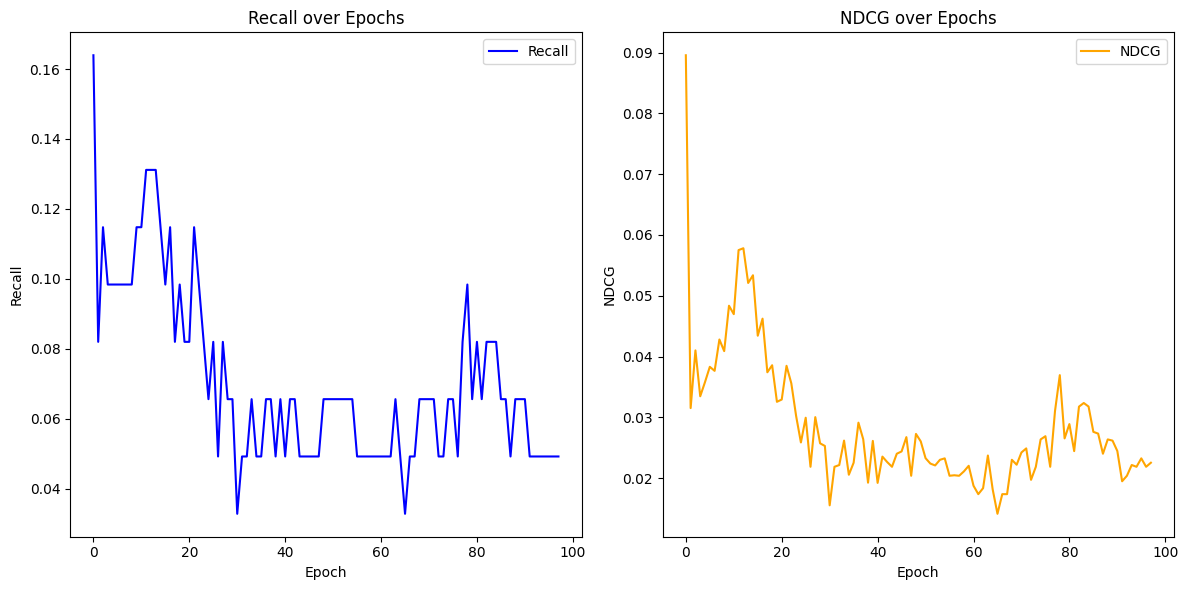

In [18]:
plt.figure(figsize=(12, 6))

# Subplot for Recall
plt.subplot(1, 2, 1)
plt.plot(bpr_recall_history, label='Recall', color='blue')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Subplot for NDCG
plt.subplot(1, 2, 2)
plt.plot(bpr_ndcg_history, label='NDCG', color='orange')
plt.title('NDCG over Epochs')
plt.xlabel('Epoch')
plt.ylabel('NDCG')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [19]:
# Additional parameters for SharpCF
lambda_reg = 1  # Regularization parameter
E = 3  # Epoch window for trajectory loss
E_start = 50  # Start epoch for trajectory loss

In [20]:
class SharpCFLoss(nn.Module):
    def __init__(self):
        super(SharpCFLoss, self).__init__()
        self.previous_scores = {}

    def forward(self, model, batch_index, user, item_i, item_j, epoch):
        prediction_i, prediction_j = model(user, item_i, item_j)
        bpr_loss = - (prediction_i - prediction_j).sigmoid().log().sum()

        # Calculate trajectory loss if applicable
        trajectory_loss = 0
        if epoch >= E_start:
            prev_key = (epoch - E, batch_index)
            if prev_key in self.previous_scores:
                prev_scores = self.previous_scores[prev_key]
                trajectory_loss = lambda_reg / len(user) * ((prediction_i - prev_scores) ** 2).sum()

        # Cache current scores for future trajectory loss calculation
        self.previous_scores[(epoch, batch_index)] = prediction_i.detach()

        return bpr_loss + trajectory_loss


In [21]:
########################### CREATE MODEL #################################
model = BPR(user_num, item_num, args.factor_num).to(device)
sharp_cf_loss = SharpCFLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.lamda)

########################### TRAINING #####################################
count, best_recall = 0, 0
SCF_recall_history = []
SCF_ndcg_history = []
# Training loop
for epoch in range(args.epochs):
    model.train()
    start_time = time.time()
    train_loader.dataset.ng_sample()

    for batch_data in train_loader:
        batch_index, user, item_i, item_j = batch_data
        batch_index = batch_index.to(device)
        user = user.to(device)
        item_i = item_i.to(device)
        item_j = item_j.to(device)
        model.zero_grad()

        # Calculate SharpCF loss
        loss = sharp_cf_loss(model, batch_index, user, item_i, item_j, epoch)
        loss.backward()
        optimizer.step()

    model.eval()
    Recall, NDCG = metrics(model, test_loader, args.top_k, device)

    SCF_recall_history.append(Recall)
    SCF_ndcg_history.append(NDCG)


    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
        time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Recall: {:.3f}\tNDCG: {:.3f}".format(np.mean(Recall), np.mean(NDCG)))

    if Recall > best_recall:
      best_recall, best_ndcg, best_epoch = Recall, NDCG, epoch
      if args.out:
        if not os.path.exists(model_path):
          os.mkdir(model_path)
        torch.save(model, '{}BPR.pt'.format(model_path))

print("End. Best epoch {:03d}: Recall = {:.3f}, \
	NDCG = {:.3f}".format(best_epoch, best_recall, best_ndcg))

The time elapse of epoch 000 is: 00: 00: 09
Recall: 0.131	NDCG: 0.059
The time elapse of epoch 001 is: 00: 00: 10
Recall: 0.115	NDCG: 0.043
The time elapse of epoch 002 is: 00: 00: 09
Recall: 0.148	NDCG: 0.050
The time elapse of epoch 003 is: 00: 00: 09
Recall: 0.098	NDCG: 0.037
The time elapse of epoch 004 is: 00: 00: 08
Recall: 0.082	NDCG: 0.033
The time elapse of epoch 005 is: 00: 00: 09
Recall: 0.115	NDCG: 0.045
The time elapse of epoch 006 is: 00: 00: 09
Recall: 0.098	NDCG: 0.041
The time elapse of epoch 007 is: 00: 00: 08
Recall: 0.115	NDCG: 0.045
The time elapse of epoch 008 is: 00: 00: 09
Recall: 0.098	NDCG: 0.041
The time elapse of epoch 009 is: 00: 00: 09
Recall: 0.098	NDCG: 0.042
The time elapse of epoch 010 is: 00: 00: 09
Recall: 0.098	NDCG: 0.046
The time elapse of epoch 011 is: 00: 00: 08
Recall: 0.115	NDCG: 0.048
The time elapse of epoch 012 is: 00: 00: 09
Recall: 0.115	NDCG: 0.047
The time elapse of epoch 013 is: 00: 00: 09
Recall: 0.131	NDCG: 0.054
The time elapse of e

Exception ignored in: <function _xla_gc_callback at 0x7fa44cbe0160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    xla_client._xla.collect_garbage()
KeyboardInterrupt: 


KeyboardInterrupt: ignored

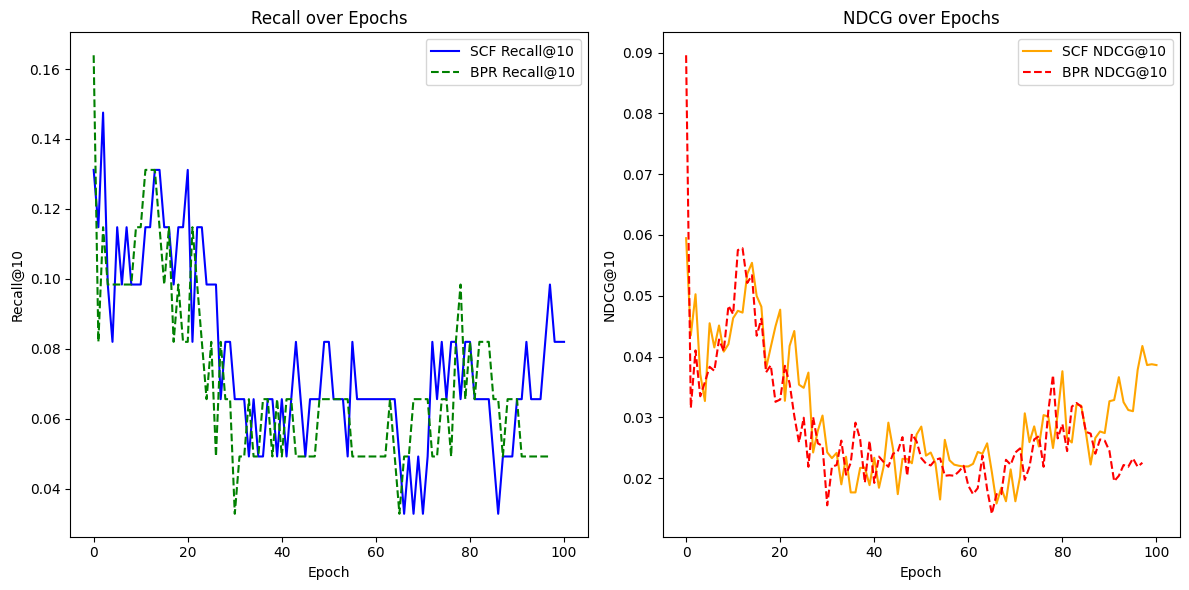

In [23]:
plt.figure(figsize=(12, 6))

# Subplot for Recall
plt.subplot(1, 2, 1)
plt.plot(SCF_recall_history[:101], label='SCF Recall@10', color='blue')
plt.plot(bpr_recall_history, label='BPR Recall@10', color='green', linestyle='--')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall@10')
plt.legend()

# Subplot for NDCG
plt.subplot(1, 2, 2)
plt.plot(SCF_ndcg_history[:101], label='SCF NDCG@10', color='orange')
plt.plot(bpr_ndcg_history, label='BPR NDCG@10', color='red', linestyle='--')
plt.title('NDCG over Epochs')
plt.xlabel('Epoch')
plt.ylabel('NDCG@10')
plt.legend()

plt.tight_layout()
plt.show()

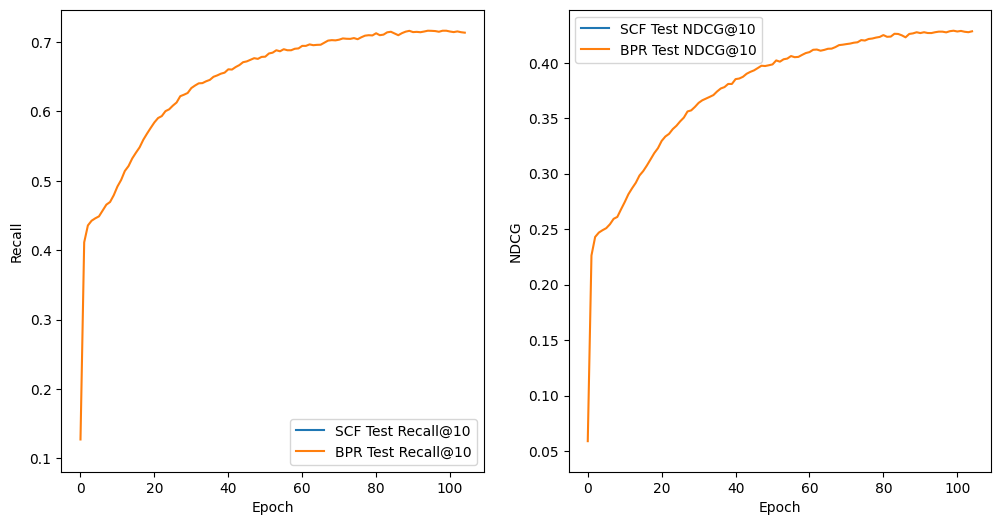

The time elapse of epoch 000 is: 00: 00: 13
Recall: 0.111	NDCG: 0.050


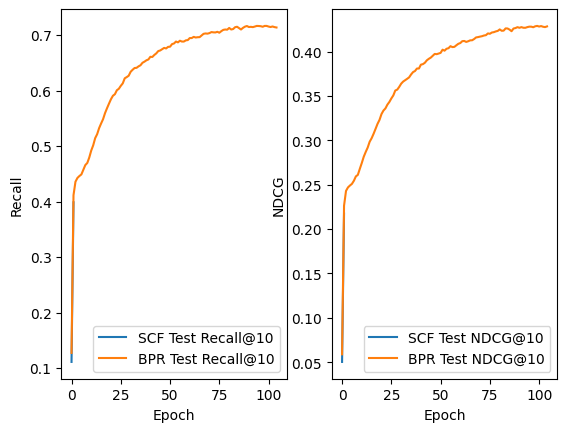

The time elapse of epoch 001 is: 00: 00: 13
Recall: 0.399	NDCG: 0.217


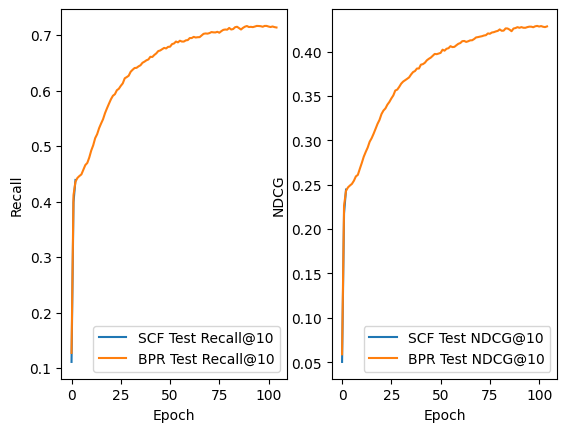

The time elapse of epoch 002 is: 00: 00: 13
Recall: 0.439	NDCG: 0.244


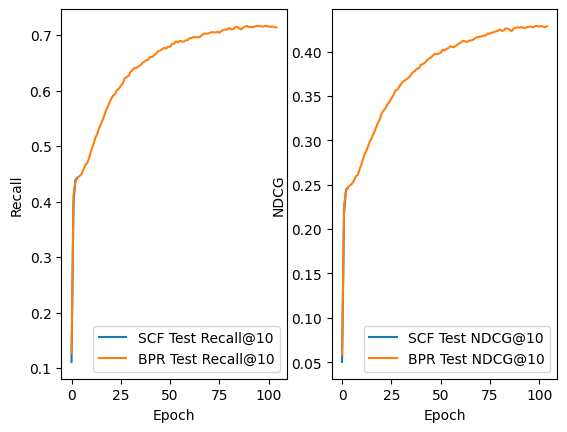

The time elapse of epoch 003 is: 00: 00: 13
Recall: 0.443	NDCG: 0.247


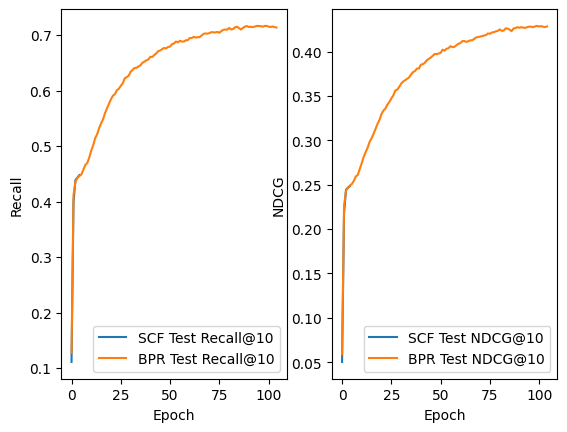

The time elapse of epoch 004 is: 00: 00: 14
Recall: 0.448	NDCG: 0.248


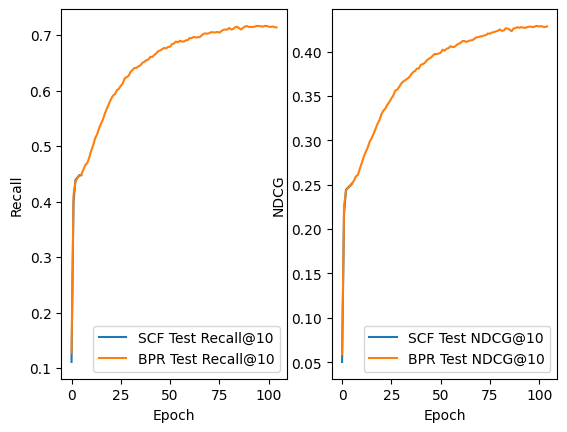

The time elapse of epoch 005 is: 00: 00: 13
Recall: 0.448	NDCG: 0.251


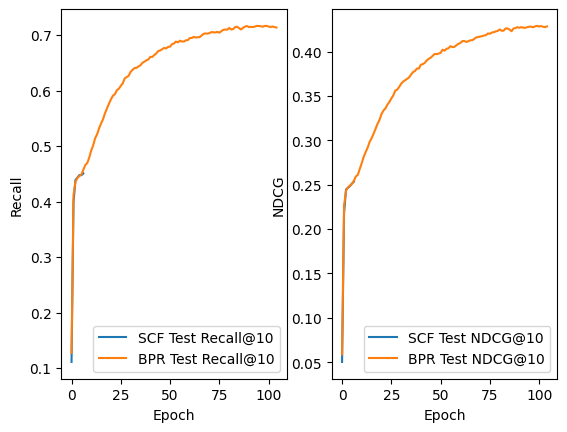

The time elapse of epoch 006 is: 00: 00: 13
Recall: 0.451	NDCG: 0.253


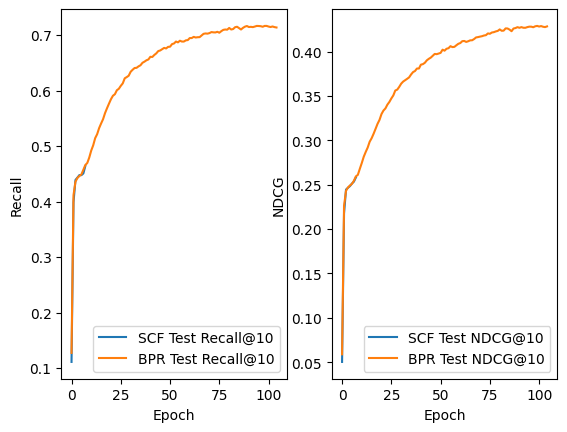

The time elapse of epoch 007 is: 00: 00: 12
Recall: 0.464	NDCG: 0.258


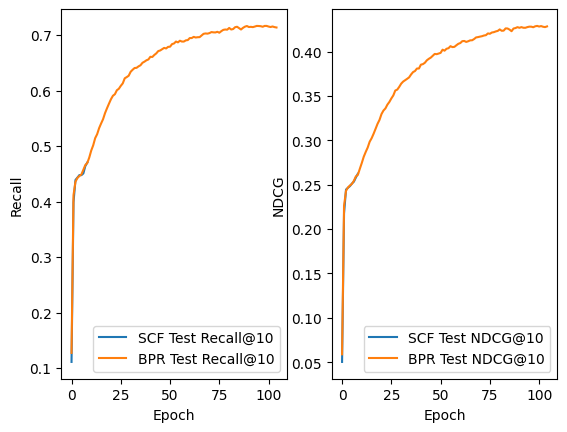

The time elapse of epoch 008 is: 00: 00: 13
Recall: 0.470	NDCG: 0.262


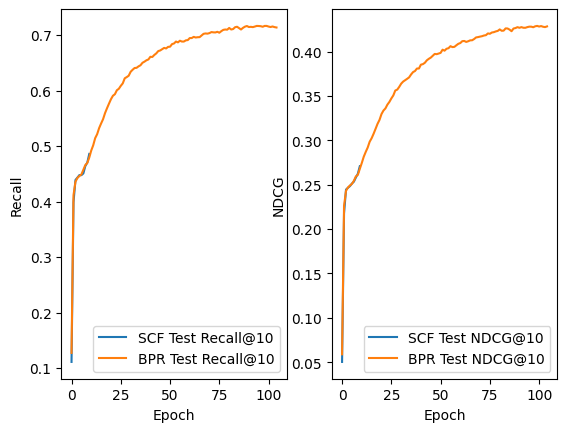

The time elapse of epoch 009 is: 00: 00: 12
Recall: 0.486	NDCG: 0.271


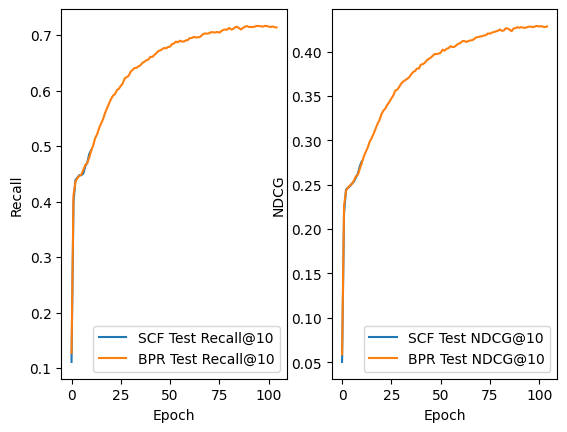

The time elapse of epoch 010 is: 00: 00: 13
Recall: 0.493	NDCG: 0.276


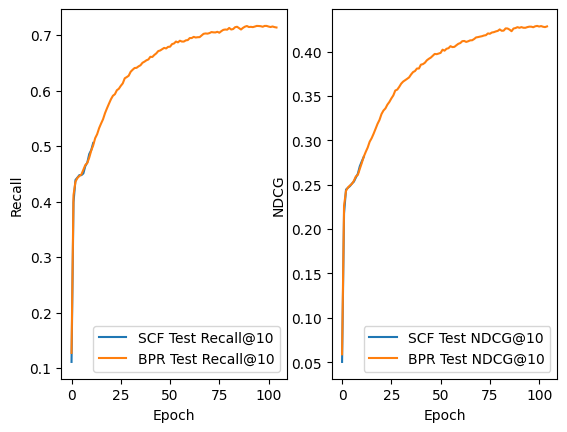

The time elapse of epoch 011 is: 00: 00: 12
Recall: 0.506	NDCG: 0.281


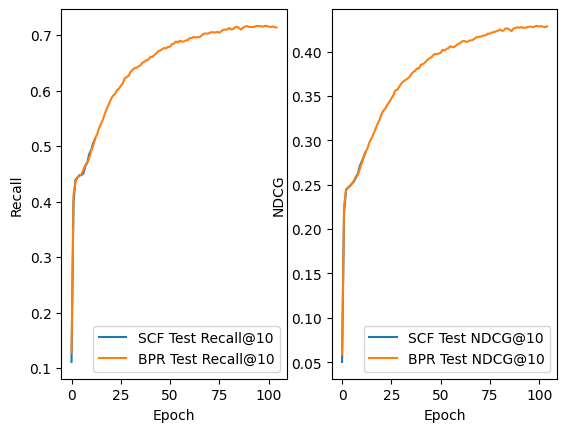

The time elapse of epoch 012 is: 00: 00: 13
Recall: 0.513	NDCG: 0.287


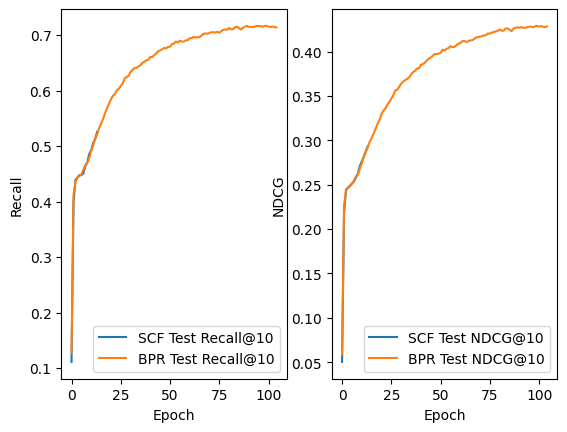

The time elapse of epoch 013 is: 00: 00: 13
Recall: 0.526	NDCG: 0.293


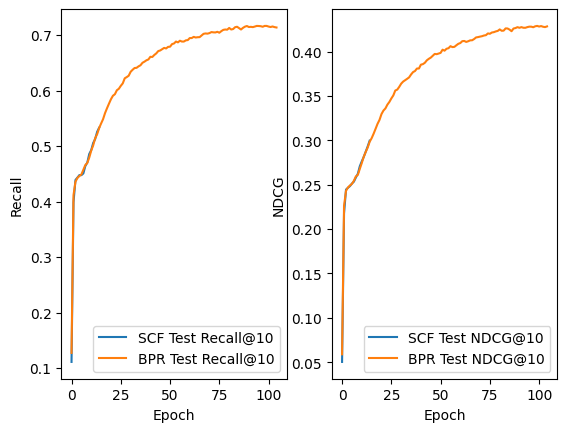

The time elapse of epoch 014 is: 00: 00: 13
Recall: 0.533	NDCG: 0.300


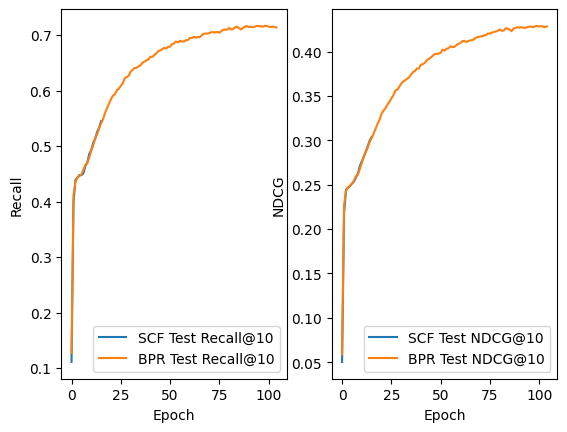

The time elapse of epoch 015 is: 00: 00: 12
Recall: 0.545	NDCG: 0.304


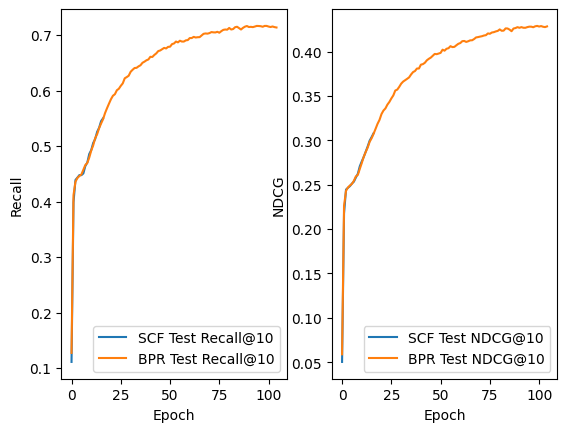

The time elapse of epoch 016 is: 00: 00: 13
Recall: 0.550	NDCG: 0.308


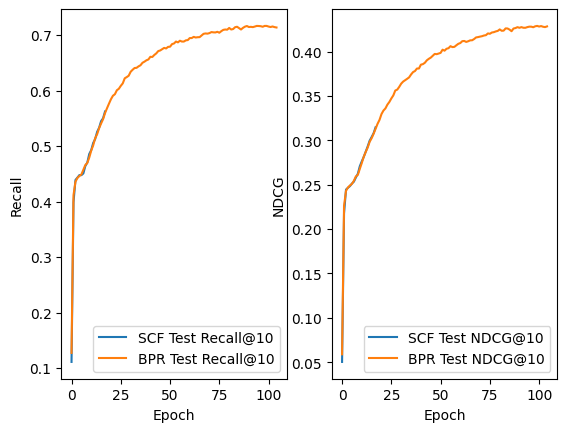

The time elapse of epoch 017 is: 00: 00: 13
Recall: 0.562	NDCG: 0.315


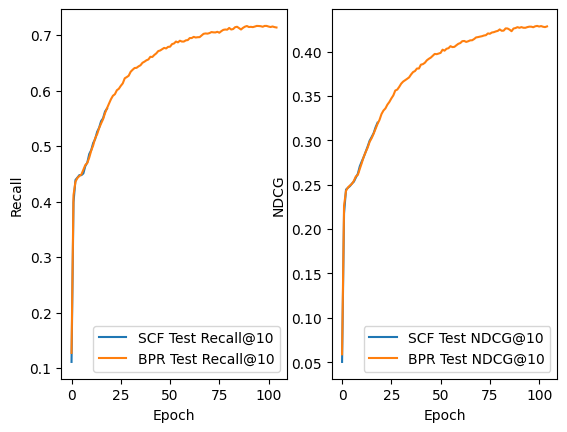

The time elapse of epoch 018 is: 00: 00: 13
Recall: 0.567	NDCG: 0.320


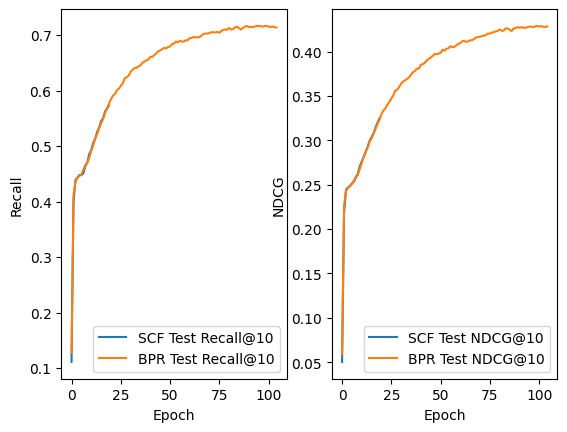

The time elapse of epoch 019 is: 00: 00: 13
Recall: 0.573	NDCG: 0.325


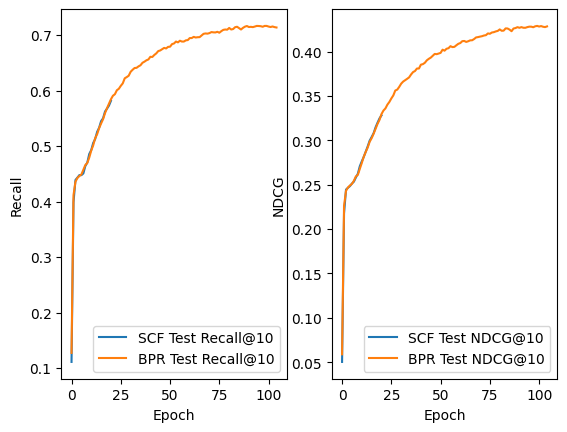

The time elapse of epoch 020 is: 00: 00: 13
Recall: 0.581	NDCG: 0.328


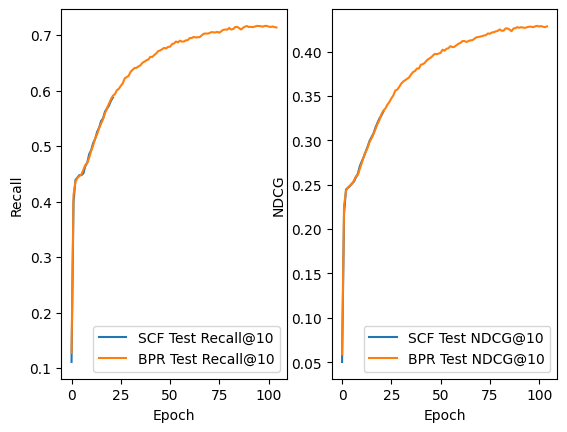

The time elapse of epoch 021 is: 00: 00: 12
Recall: 0.587	NDCG: 0.333


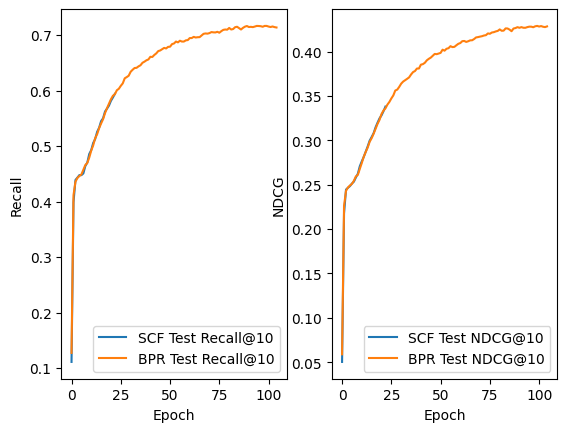

The time elapse of epoch 022 is: 00: 00: 13
Recall: 0.594	NDCG: 0.338


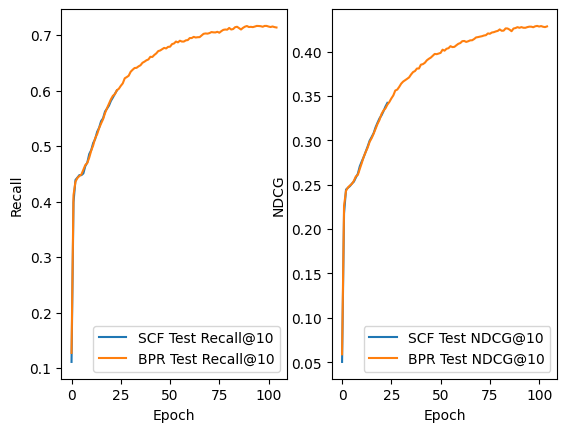

The time elapse of epoch 023 is: 00: 00: 12
Recall: 0.600	NDCG: 0.342


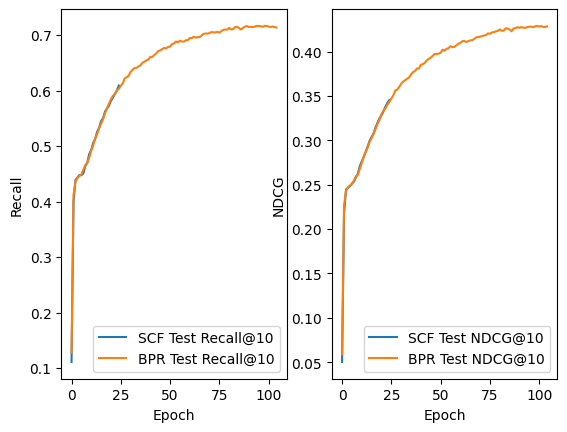

The time elapse of epoch 024 is: 00: 00: 15
Recall: 0.609	NDCG: 0.345


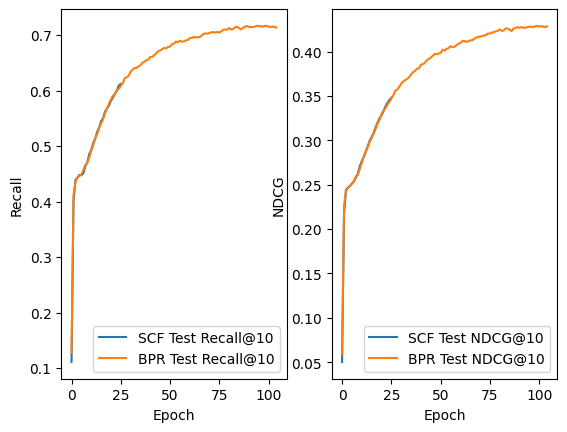

The time elapse of epoch 025 is: 00: 00: 12
Recall: 0.612	NDCG: 0.348


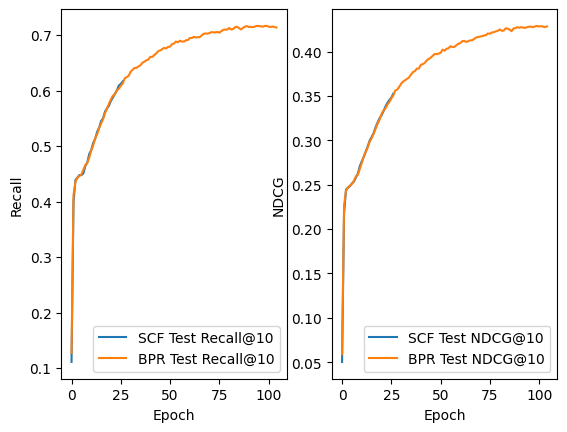

The time elapse of epoch 026 is: 00: 00: 12
Recall: 0.617	NDCG: 0.353


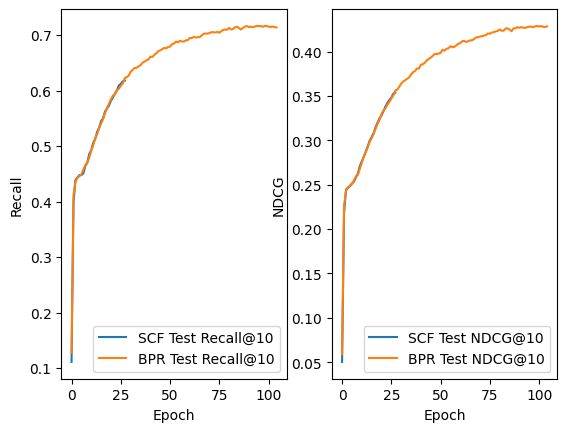

The time elapse of epoch 027 is: 00: 00: 12
Recall: 0.618	NDCG: 0.354


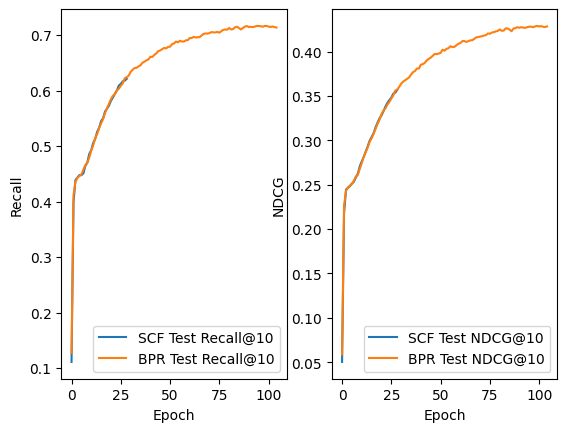

The time elapse of epoch 028 is: 00: 00: 13
Recall: 0.621	NDCG: 0.357


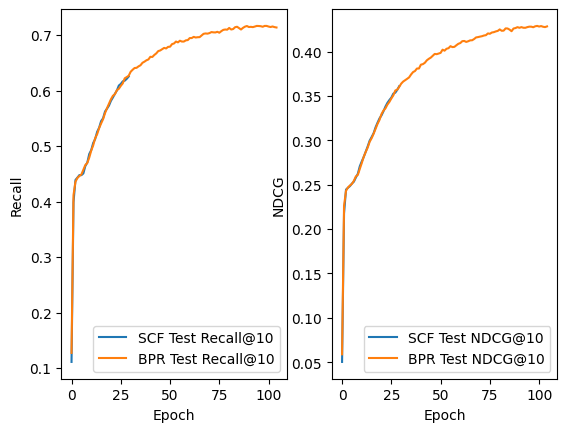

The time elapse of epoch 029 is: 00: 00: 12
Recall: 0.625	NDCG: 0.361


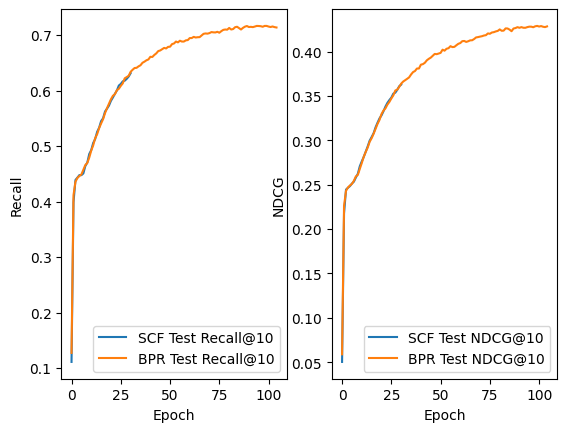

The time elapse of epoch 030 is: 00: 00: 13
Recall: 0.631	NDCG: 0.363


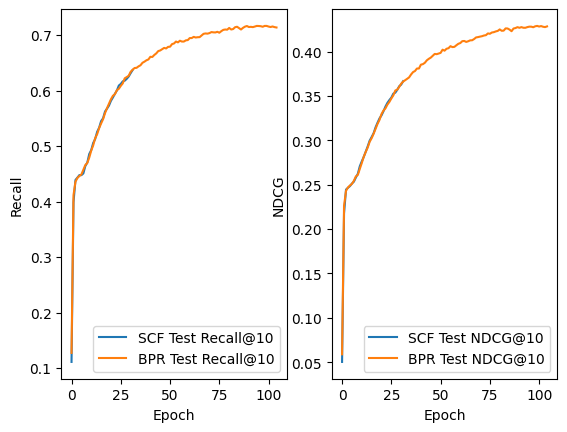

The time elapse of epoch 031 is: 00: 00: 13
Recall: 0.637	NDCG: 0.367


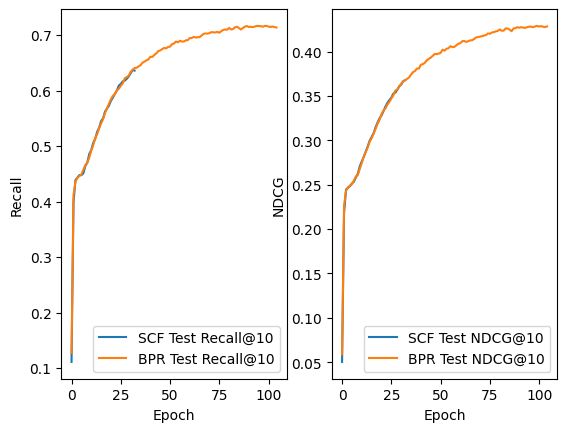

The time elapse of epoch 032 is: 00: 00: 12
Recall: 0.636	NDCG: 0.368


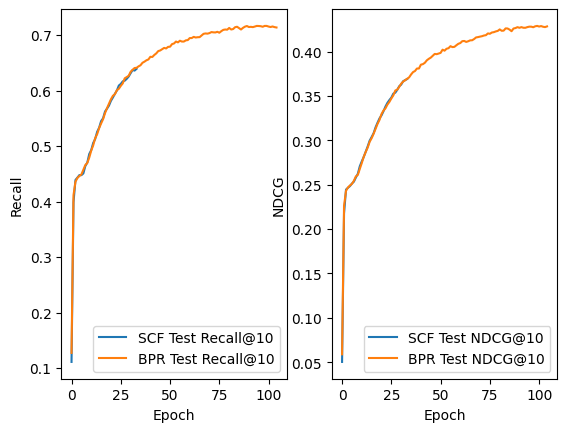

The time elapse of epoch 033 is: 00: 00: 13
Recall: 0.639	NDCG: 0.369


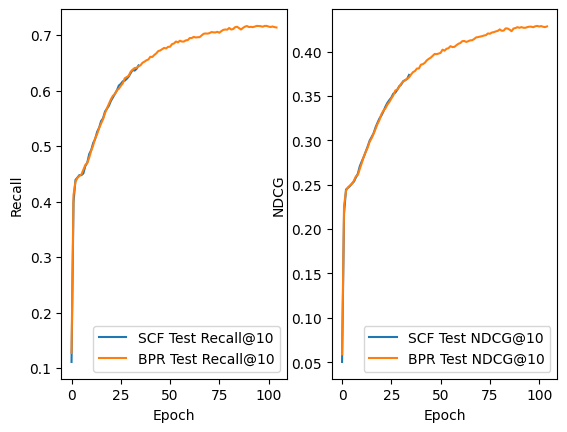

The time elapse of epoch 034 is: 00: 00: 13
Recall: 0.645	NDCG: 0.374


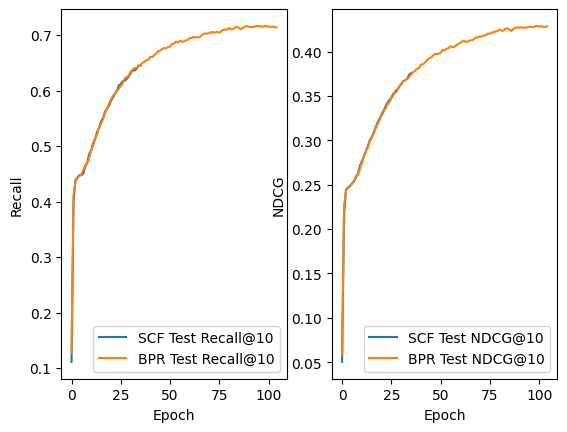

The time elapse of epoch 035 is: 00: 00: 13
Recall: 0.645	NDCG: 0.376


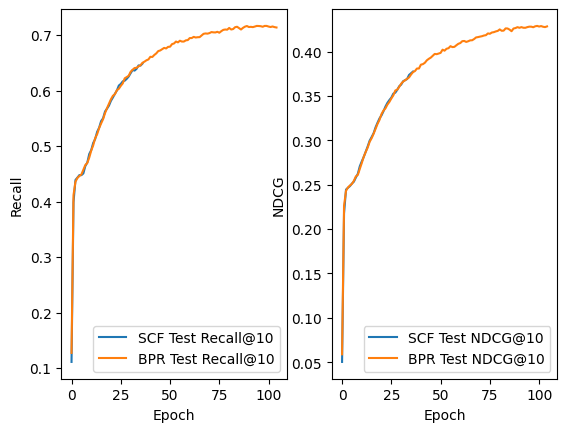

The time elapse of epoch 036 is: 00: 00: 13
Recall: 0.649	NDCG: 0.377


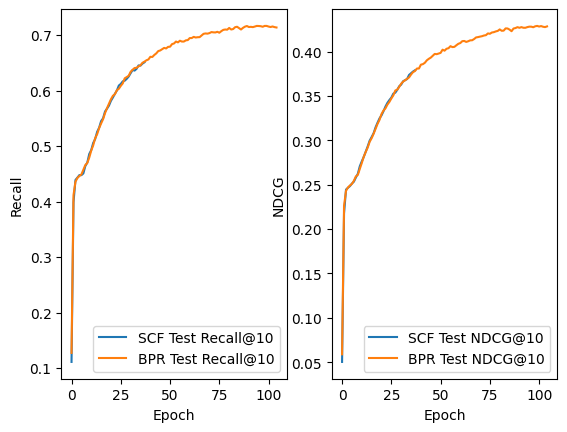

The time elapse of epoch 037 is: 00: 00: 13
Recall: 0.651	NDCG: 0.379


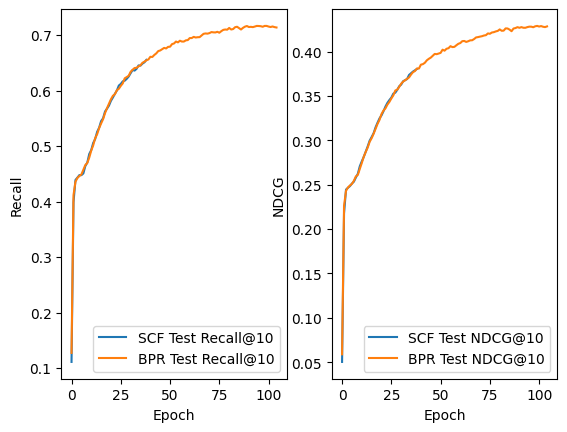

The time elapse of epoch 038 is: 00: 00: 13
Recall: 0.655	NDCG: 0.380


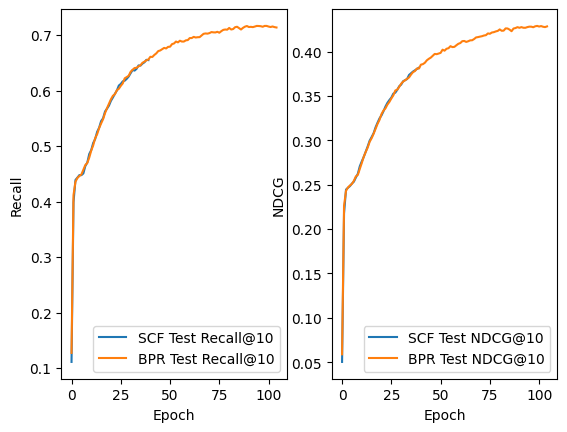

The time elapse of epoch 039 is: 00: 00: 13
Recall: 0.655	NDCG: 0.382


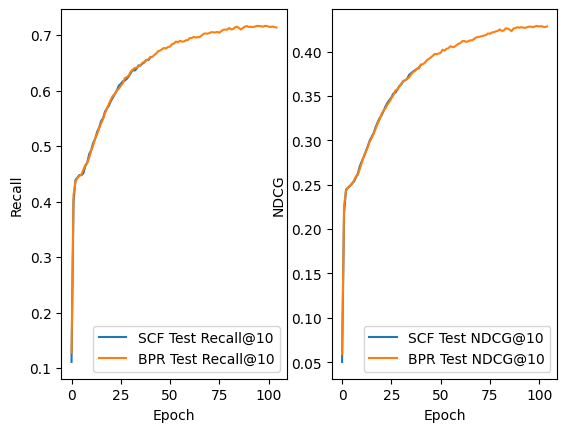

The time elapse of epoch 040 is: 00: 00: 13
Recall: 0.659	NDCG: 0.385


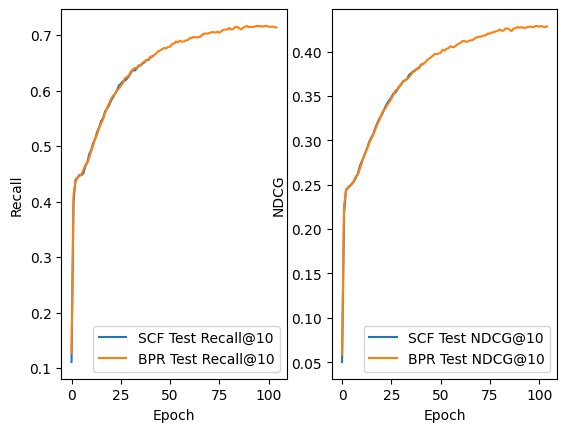

The time elapse of epoch 041 is: 00: 00: 13
Recall: 0.662	NDCG: 0.386


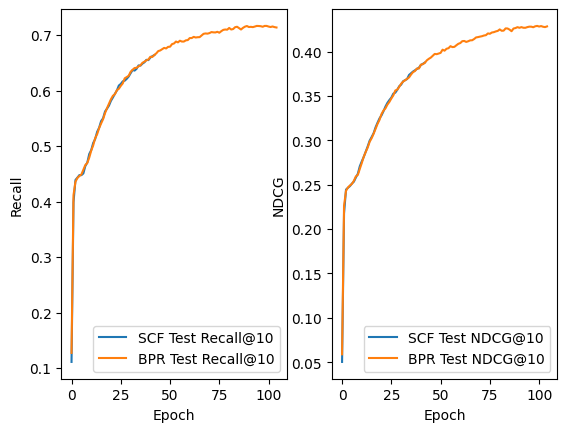

The time elapse of epoch 042 is: 00: 00: 13
Recall: 0.664	NDCG: 0.388


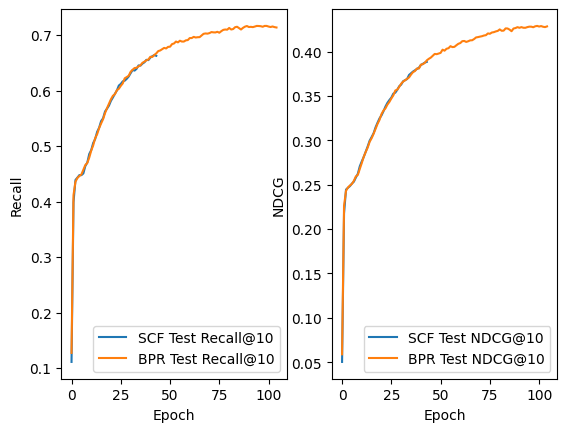

The time elapse of epoch 043 is: 00: 00: 13
Recall: 0.663	NDCG: 0.388


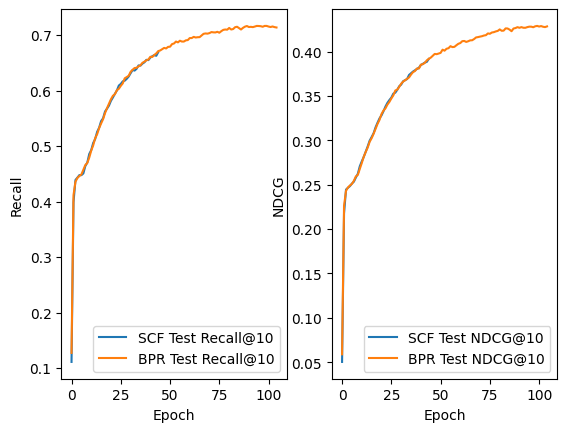

The time elapse of epoch 044 is: 00: 00: 13
Recall: 0.669	NDCG: 0.392


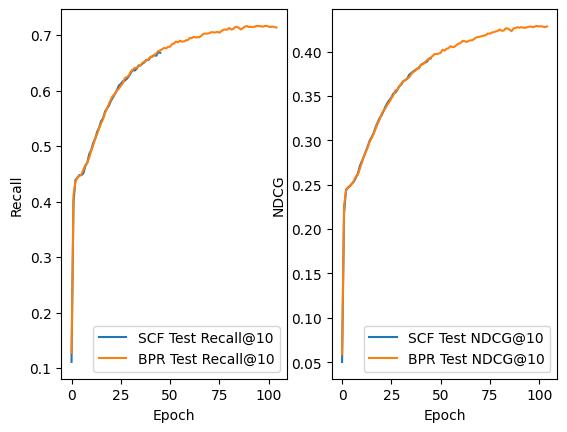

The time elapse of epoch 045 is: 00: 00: 13
Recall: 0.668	NDCG: 0.392


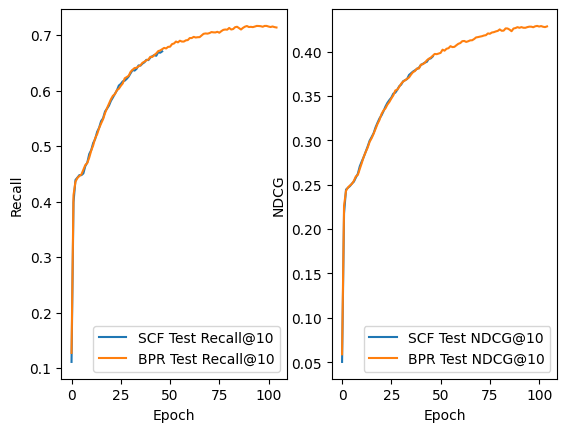

The time elapse of epoch 046 is: 00: 00: 13
Recall: 0.671	NDCG: 0.394


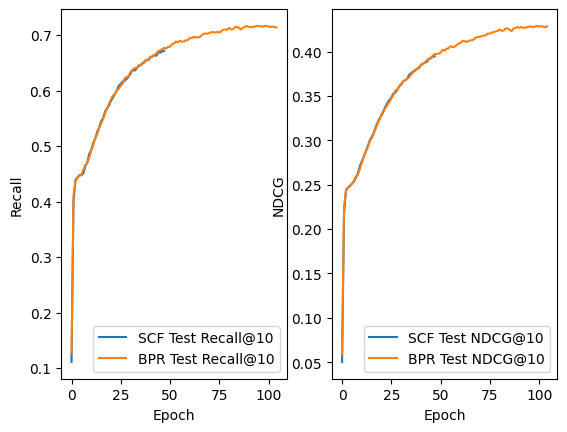

The time elapse of epoch 047 is: 00: 00: 13
Recall: 0.672	NDCG: 0.395


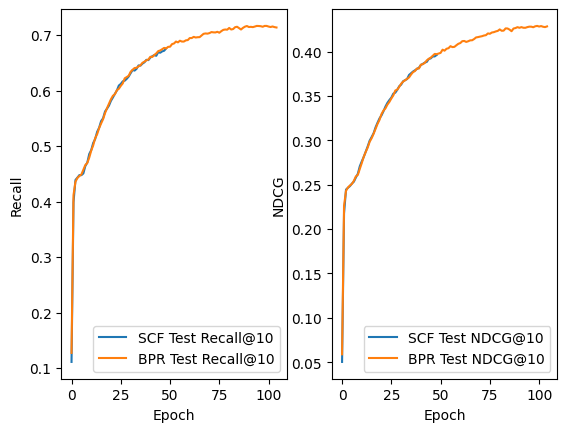

The time elapse of epoch 048 is: 00: 00: 13
Recall: 0.676	NDCG: 0.396


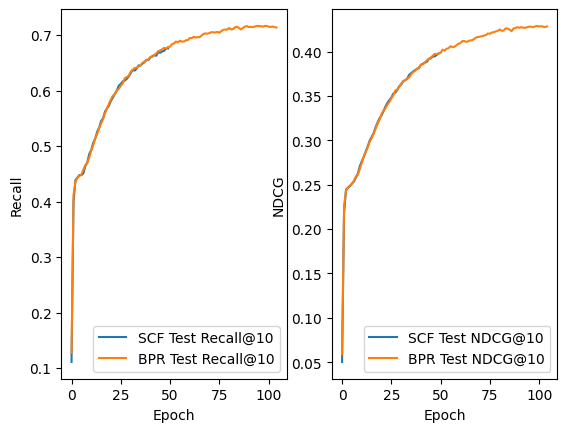

The time elapse of epoch 049 is: 00: 00: 13
Recall: 0.676	NDCG: 0.398


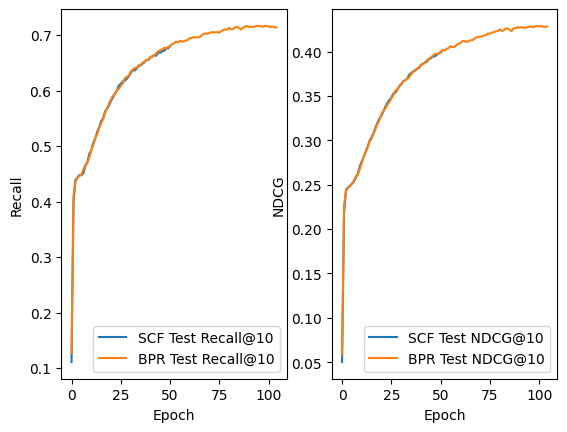

The time elapse of epoch 050 is: 00: 00: 13
Recall: 0.680	NDCG: 0.400


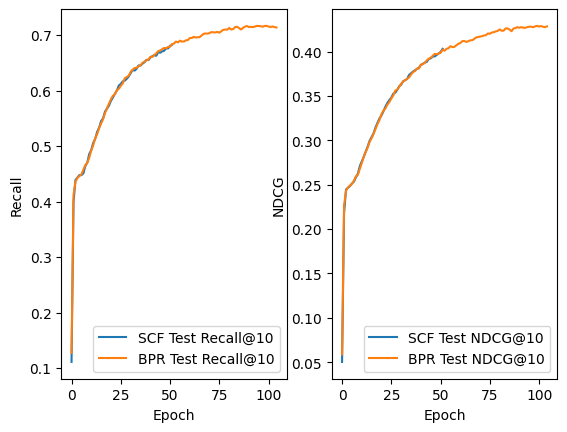

The time elapse of epoch 051 is: 00: 00: 13
Recall: 0.682	NDCG: 0.403


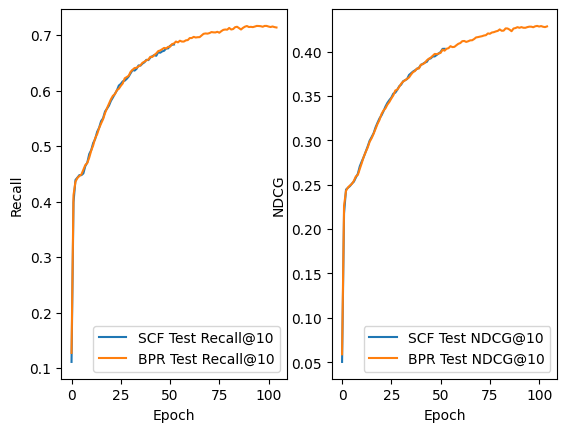

The time elapse of epoch 052 is: 00: 00: 14
Recall: 0.683	NDCG: 0.403


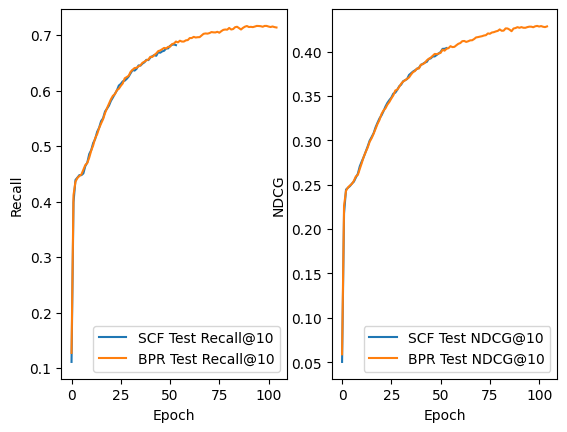

The time elapse of epoch 053 is: 00: 00: 13
Recall: 0.682	NDCG: 0.404


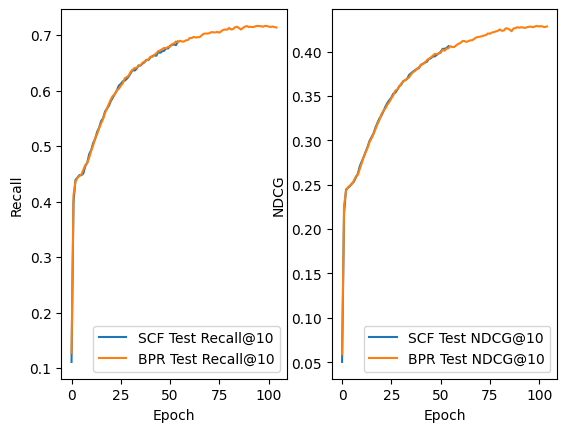

The time elapse of epoch 054 is: 00: 00: 13
Recall: 0.688	NDCG: 0.406


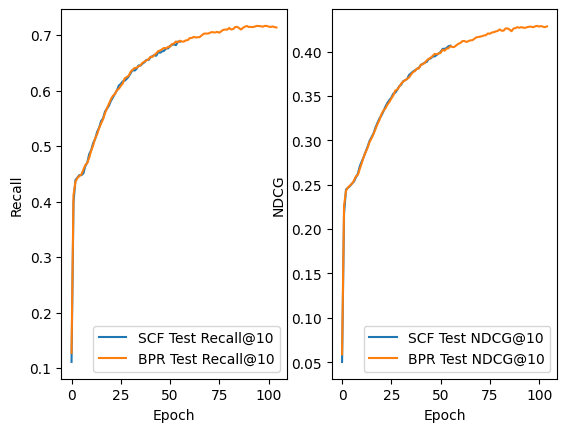

The time elapse of epoch 055 is: 00: 00: 13
Recall: 0.688	NDCG: 0.407


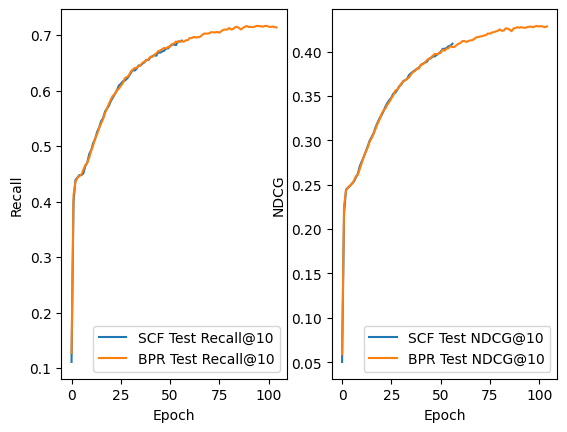

The time elapse of epoch 056 is: 00: 00: 13
Recall: 0.690	NDCG: 0.409


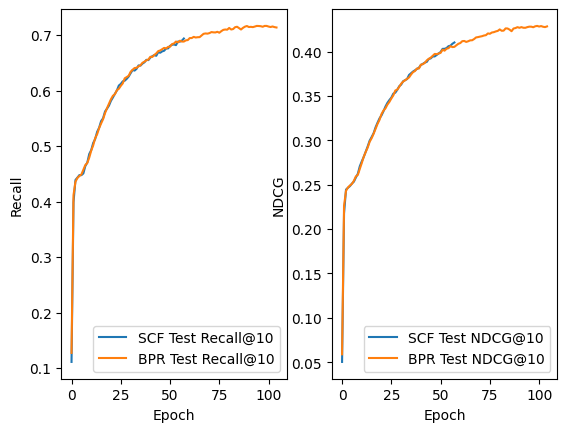

The time elapse of epoch 057 is: 00: 00: 12
Recall: 0.694	NDCG: 0.410


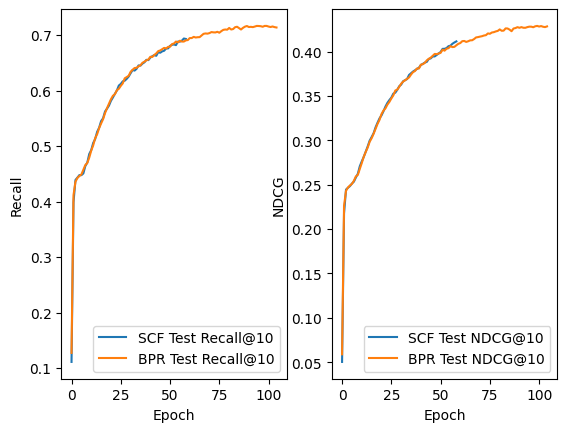

The time elapse of epoch 058 is: 00: 00: 13
Recall: 0.693	NDCG: 0.411


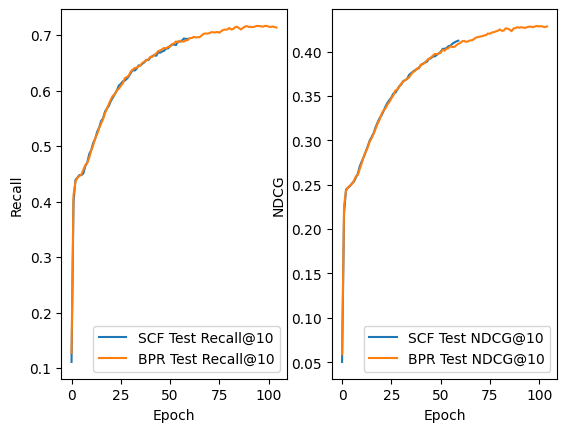

The time elapse of epoch 059 is: 00: 00: 13
Recall: 0.693	NDCG: 0.412


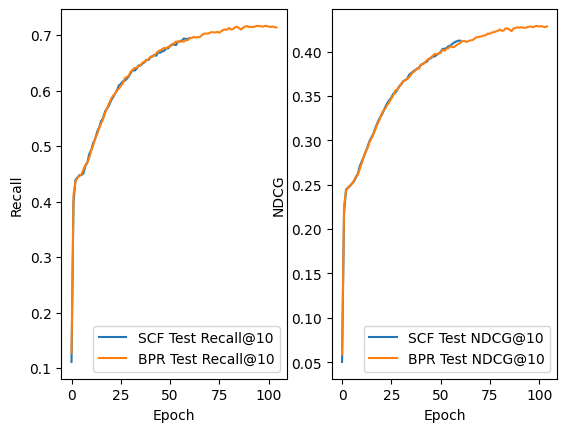

The time elapse of epoch 060 is: 00: 00: 13
Recall: 0.695	NDCG: 0.412


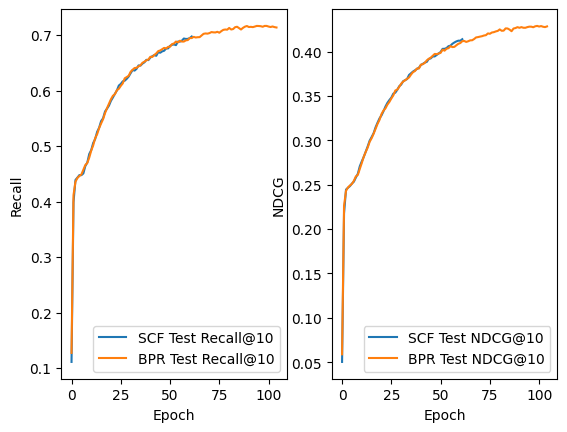

The time elapse of epoch 061 is: 00: 00: 13
Recall: 0.697	NDCG: 0.414


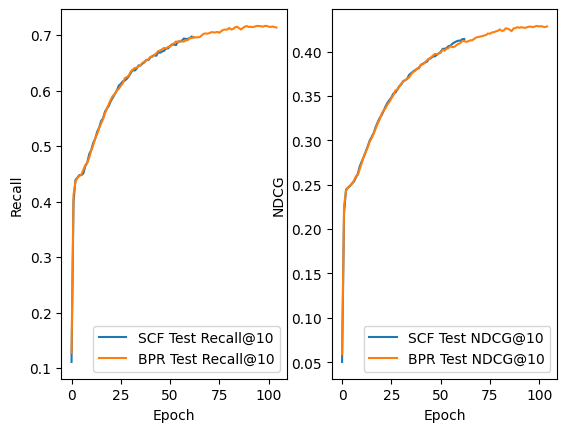

The time elapse of epoch 062 is: 00: 00: 13
Recall: 0.696	NDCG: 0.414


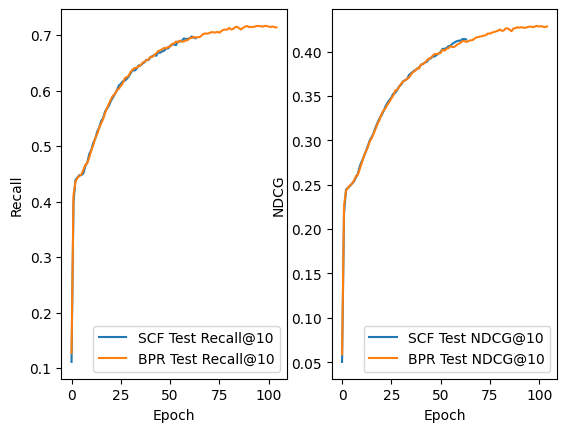

The time elapse of epoch 063 is: 00: 00: 13
Recall: 0.694	NDCG: 0.414


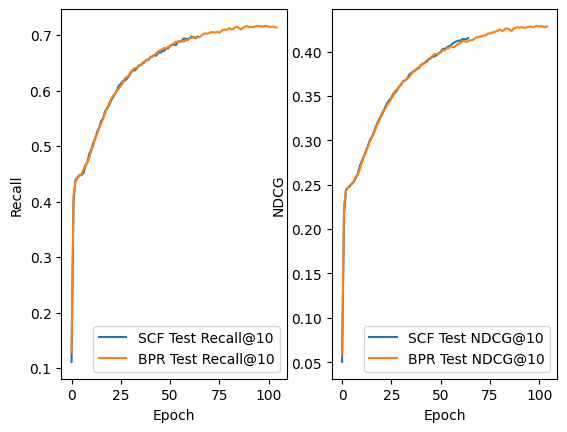

The time elapse of epoch 064 is: 00: 00: 13
Recall: 0.697	NDCG: 0.415


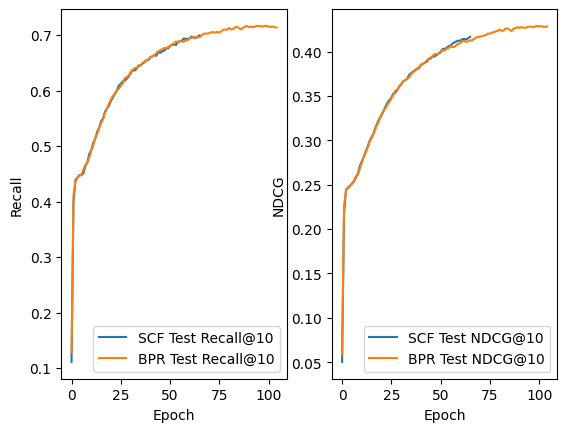

The time elapse of epoch 065 is: 00: 00: 13
Recall: 0.699	NDCG: 0.416


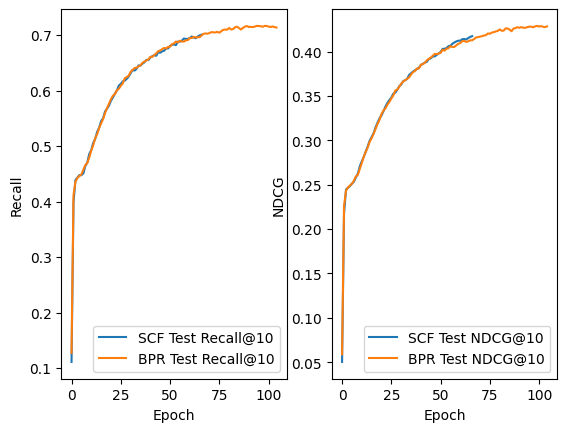

The time elapse of epoch 066 is: 00: 00: 13
Recall: 0.701	NDCG: 0.417


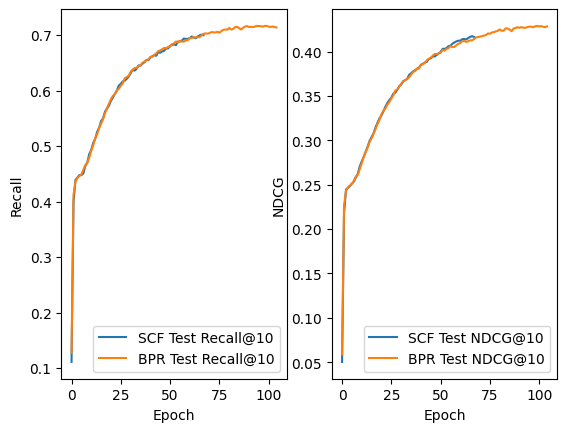

The time elapse of epoch 067 is: 00: 00: 13
Recall: 0.700	NDCG: 0.416


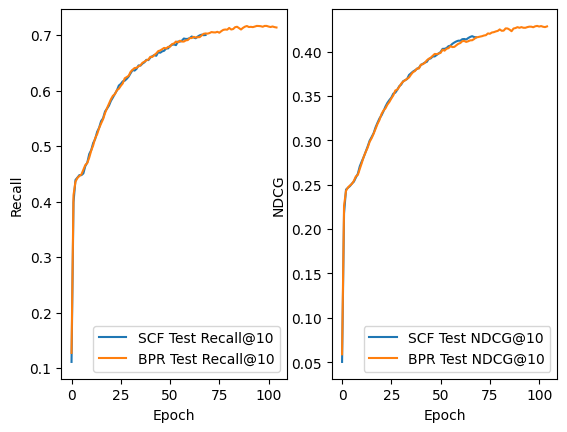

The time elapse of epoch 068 is: 00: 00: 13
Recall: 0.700	NDCG: 0.416


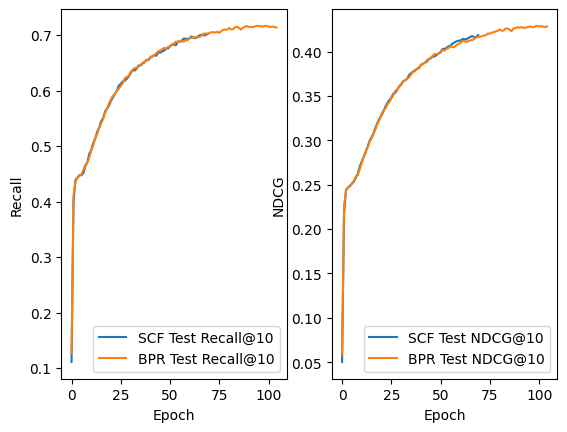

The time elapse of epoch 069 is: 00: 00: 13
Recall: 0.702	NDCG: 0.419


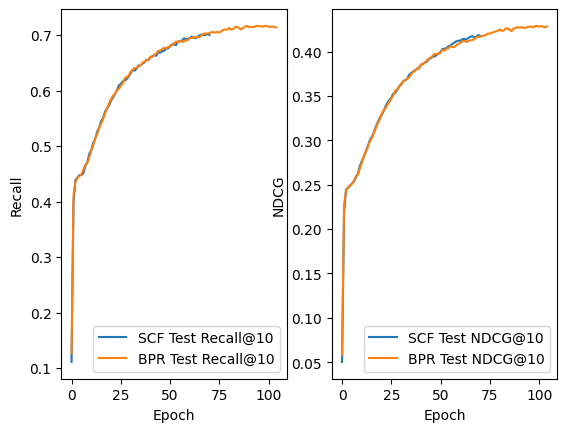

The time elapse of epoch 070 is: 00: 00: 13
Recall: 0.700	NDCG: 0.418


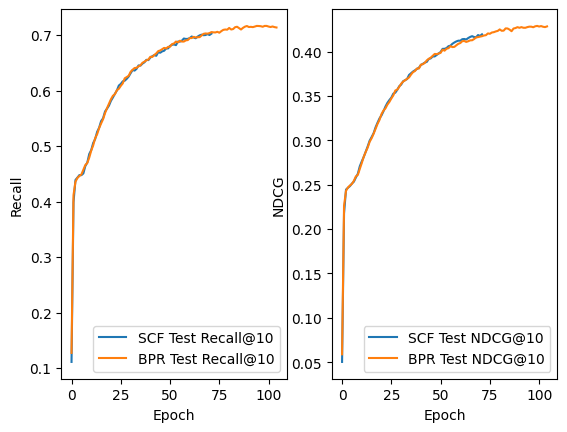

The time elapse of epoch 071 is: 00: 00: 13
Recall: 0.702	NDCG: 0.419


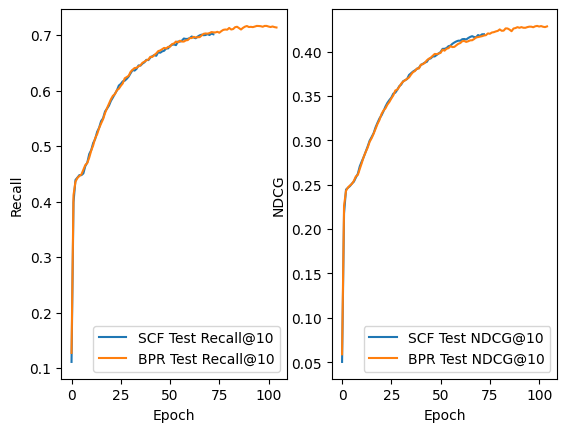

The time elapse of epoch 072 is: 00: 00: 14
Recall: 0.701	NDCG: 0.420


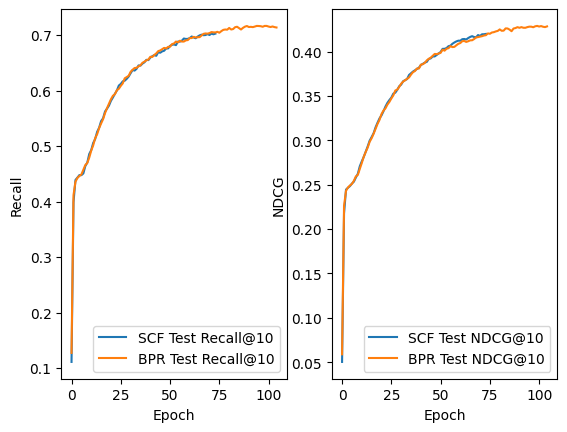

The time elapse of epoch 073 is: 00: 00: 13
Recall: 0.702	NDCG: 0.420


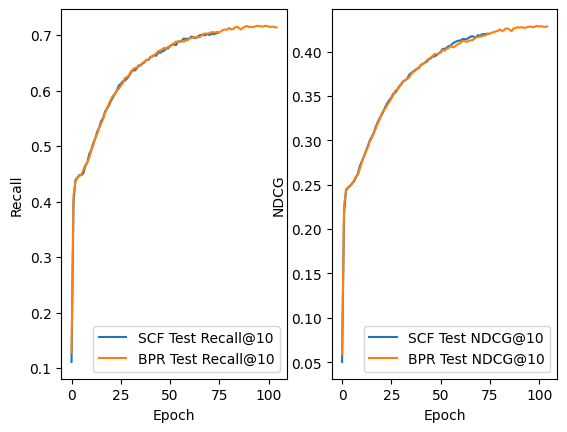

The time elapse of epoch 074 is: 00: 00: 13
Recall: 0.704	NDCG: 0.420


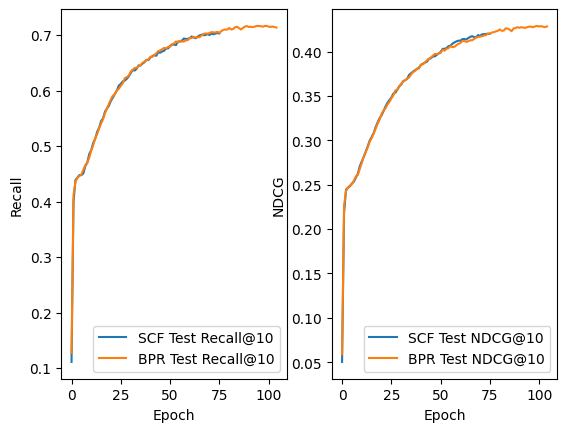

The time elapse of epoch 075 is: 00: 00: 13
Recall: 0.703	NDCG: 0.420


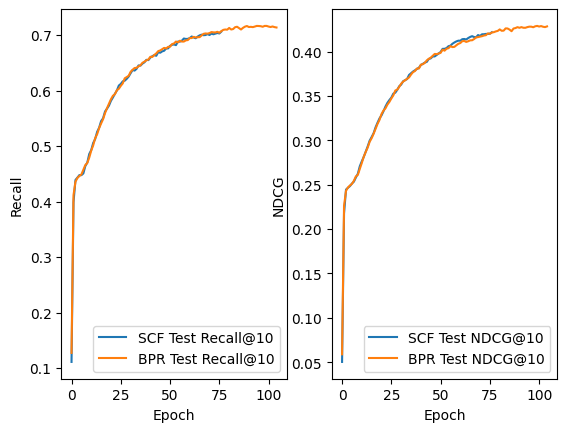

The time elapse of epoch 076 is: 00: 00: 13
Recall: 0.706	NDCG: 0.422


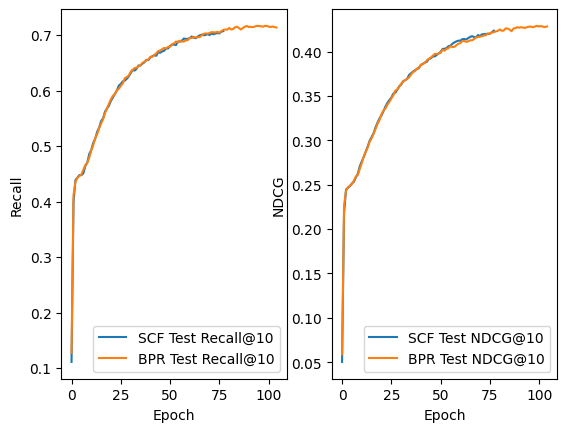

The time elapse of epoch 077 is: 00: 00: 12
Recall: 0.707	NDCG: 0.424


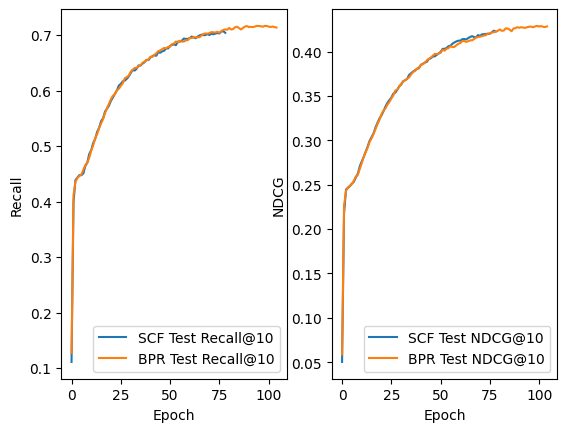

The time elapse of epoch 078 is: 00: 00: 13
Recall: 0.704	NDCG: 0.423


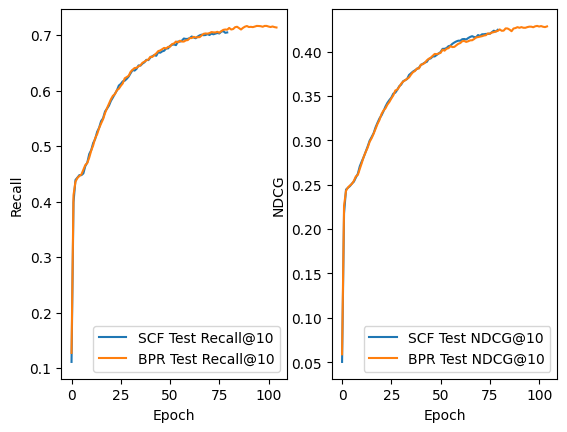

The time elapse of epoch 079 is: 00: 00: 12
Recall: 0.705	NDCG: 0.424


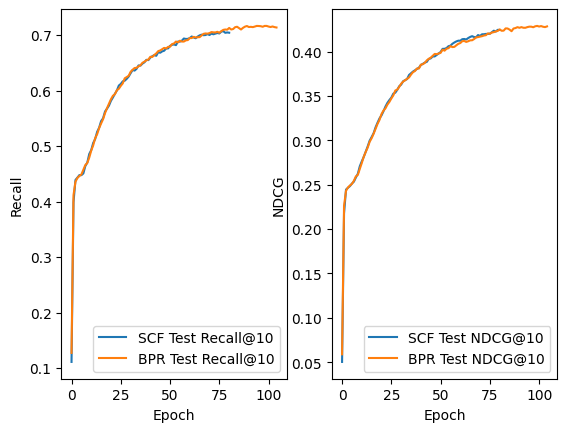

The time elapse of epoch 080 is: 00: 00: 13
Recall: 0.704	NDCG: 0.424


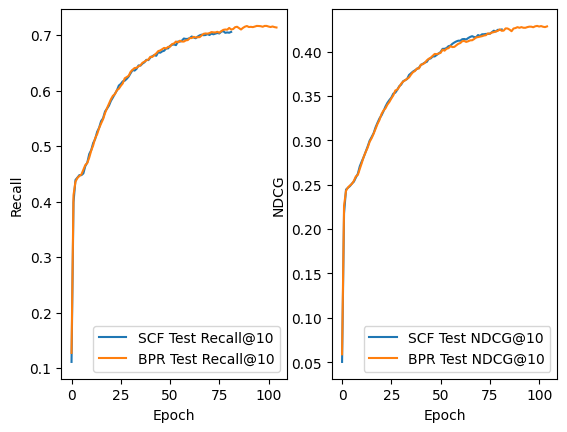

The time elapse of epoch 081 is: 00: 00: 12
Recall: 0.706	NDCG: 0.425


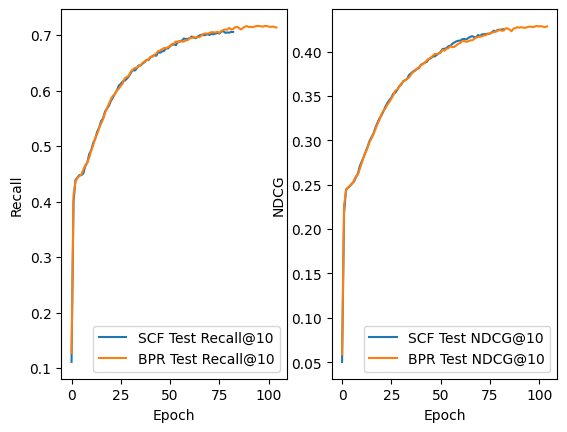

The time elapse of epoch 082 is: 00: 00: 13
Recall: 0.705	NDCG: 0.425


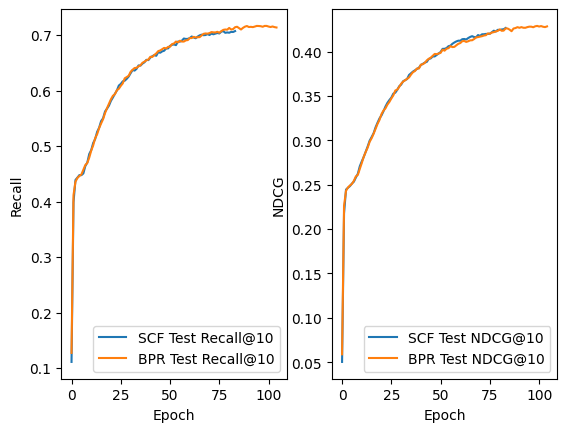

The time elapse of epoch 083 is: 00: 00: 13
Recall: 0.707	NDCG: 0.427


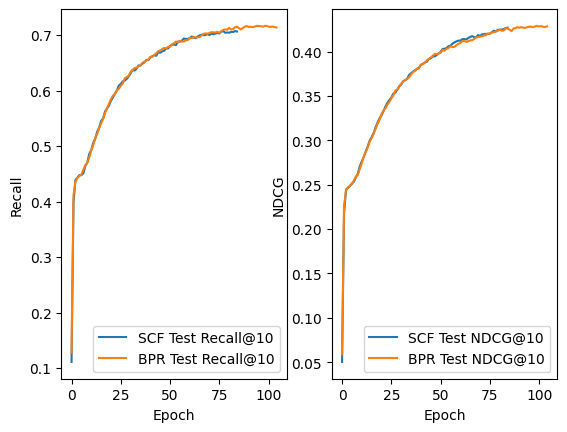

The time elapse of epoch 084 is: 00: 00: 12
Recall: 0.706	NDCG: 0.427


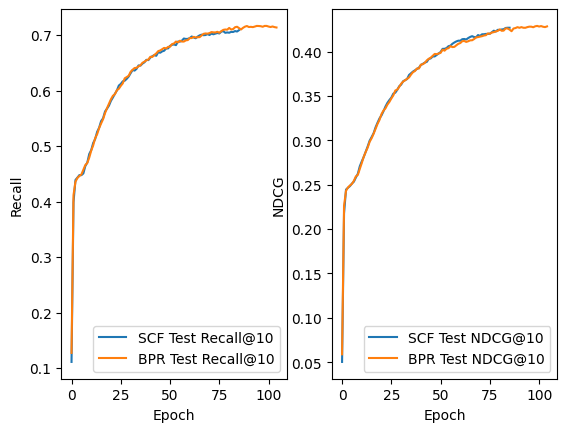

The time elapse of epoch 085 is: 00: 00: 13
Recall: 0.709	NDCG: 0.427


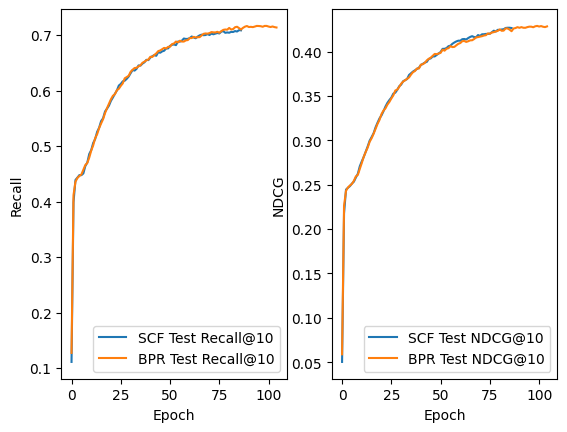

The time elapse of epoch 086 is: 00: 00: 15
Recall: 0.708	NDCG: 0.427


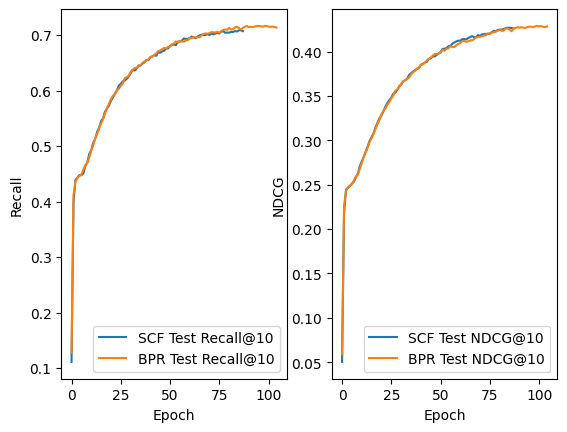

The time elapse of epoch 087 is: 00: 00: 13
Recall: 0.707	NDCG: 0.426


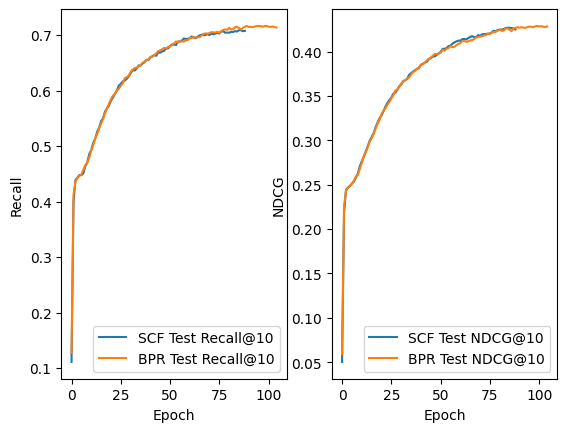

The time elapse of epoch 088 is: 00: 00: 13
Recall: 0.707	NDCG: 0.425


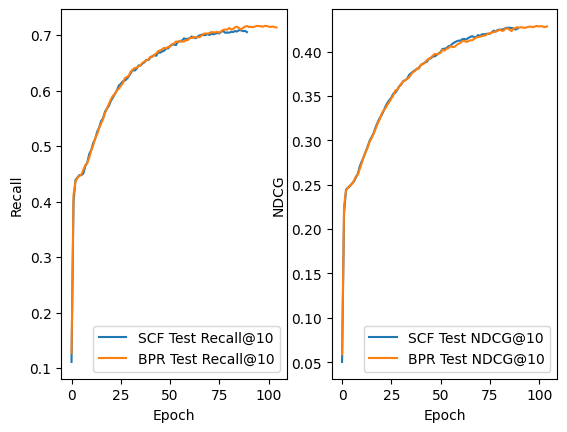

The time elapse of epoch 089 is: 00: 00: 14
Recall: 0.705	NDCG: 0.426


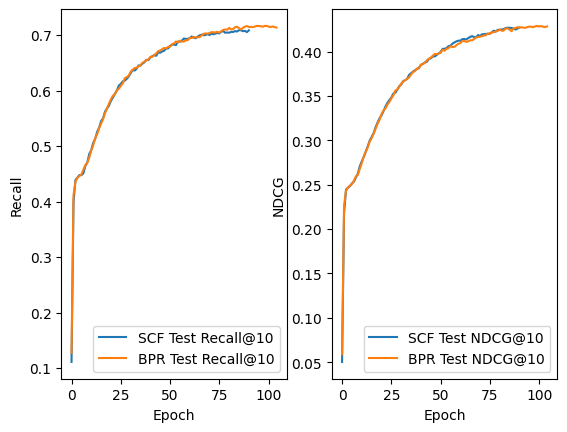

The time elapse of epoch 090 is: 00: 00: 13
Recall: 0.708	NDCG: 0.427


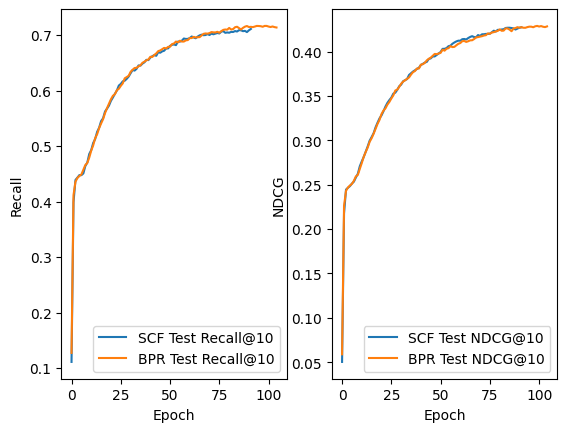

The time elapse of epoch 091 is: 00: 00: 13
Recall: 0.711	NDCG: 0.427


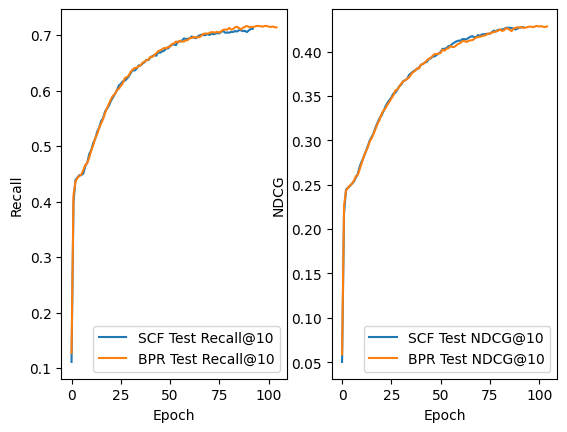

The time elapse of epoch 092 is: 00: 00: 13
Recall: 0.711	NDCG: 0.428


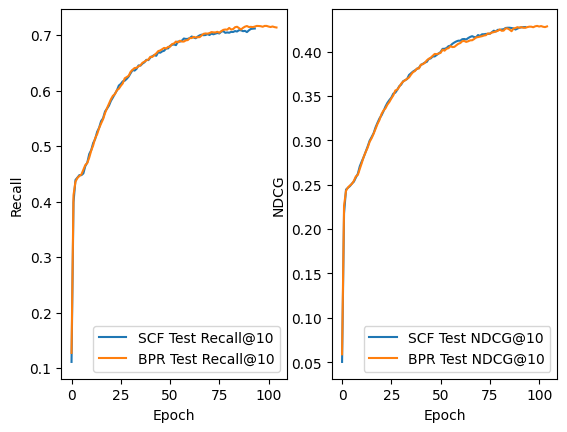

The time elapse of epoch 093 is: 00: 00: 13
Recall: 0.712	NDCG: 0.428


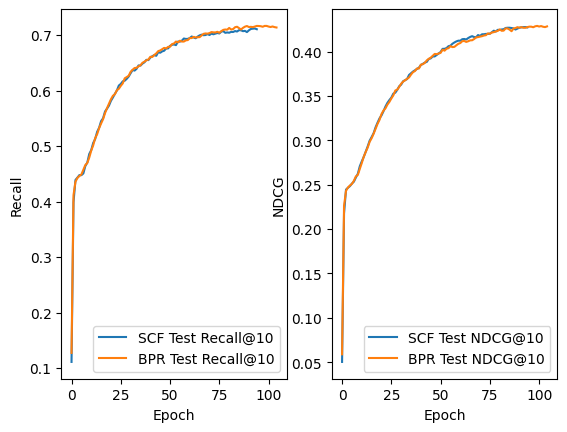

The time elapse of epoch 094 is: 00: 00: 13
Recall: 0.710	NDCG: 0.427


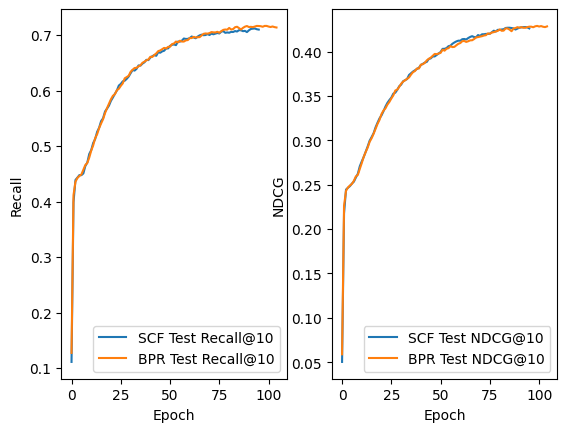

The time elapse of epoch 095 is: 00: 00: 15
Recall: 0.710	NDCG: 0.426


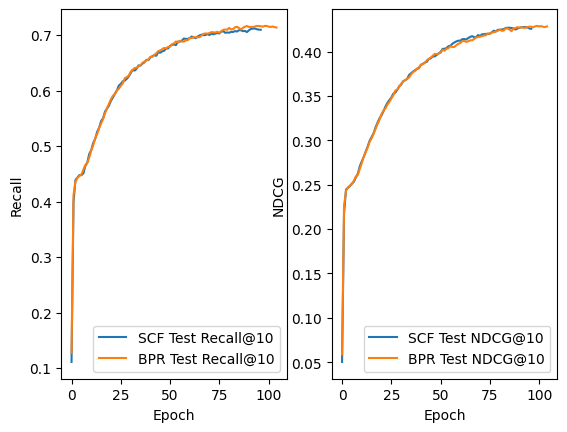

The time elapse of epoch 096 is: 00: 00: 13
Recall: 0.709	NDCG: 0.426


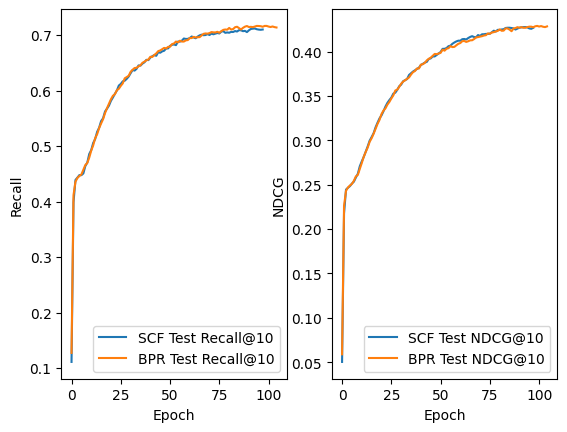

The time elapse of epoch 097 is: 00: 00: 13
Recall: 0.710	NDCG: 0.427


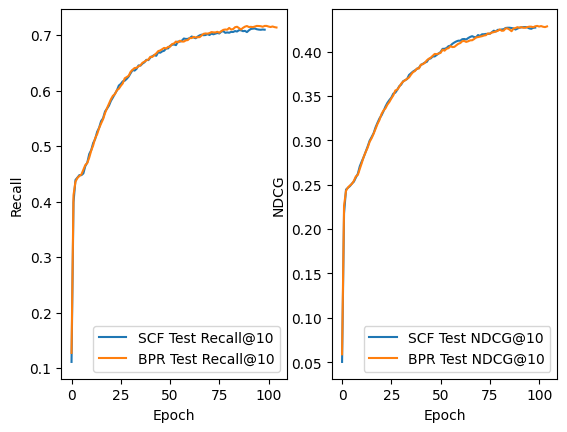

The time elapse of epoch 098 is: 00: 00: 13
Recall: 0.710	NDCG: 0.427


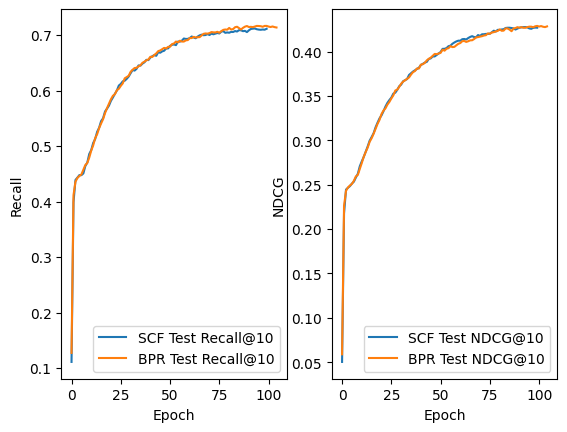

The time elapse of epoch 099 is: 00: 00: 13
Recall: 0.711	NDCG: 0.427


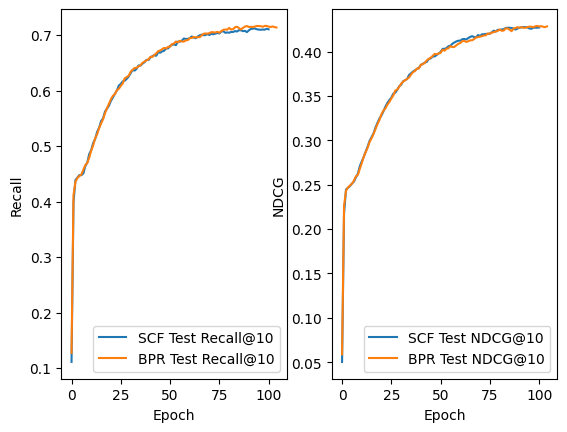

The time elapse of epoch 100 is: 00: 00: 12
Recall: 0.710	NDCG: 0.427


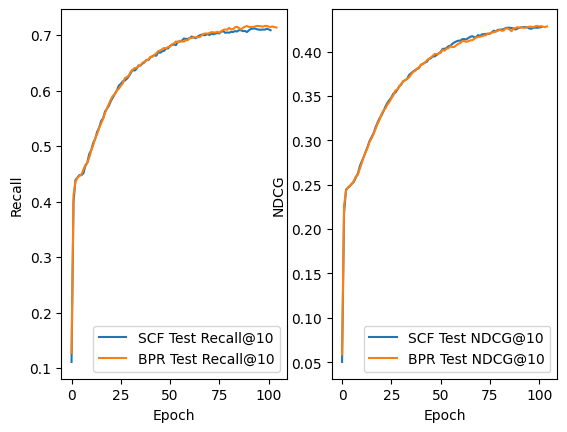

The time elapse of epoch 101 is: 00: 00: 14
Recall: 0.709	NDCG: 0.427


KeyboardInterrupt: ignored

In [29]:
model = BPR(user_num, item_num, args.factor_num).to(device)
sharp_cf_loss = SharpCFLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.lamda)
count, best_recall = 0, 0

# Initialize lists to store recall and NDCG values
SCF_recall_history = []
SCF_ndcg_history = []

# Create a figure for plotting
plt.figure(figsize=(12, 6))

for epoch in range(args.epochs):
    model.train()
    start_time = time.time()
    train_loader.dataset.ng_sample()

    for batch_data in train_loader:
        batch_index, user, item_i, item_j = batch_data
        batch_index = batch_index.to(device)
        user = user.to(device)
        item_i = item_i.to(device)
        item_j = item_j.to(device)
        model.zero_grad()

        # Calculate SharpCF loss
        loss = sharp_cf_loss(model, batch_index, user, item_i, item_j, epoch)
        loss.backward()
        optimizer.step()

    model.eval()
    Recall, NDCG = metrics(model, test_loader, args.top_k, device)

    SCF_recall_history.append(np.mean(Recall))
    SCF_ndcg_history.append(np.mean(NDCG))

    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
        time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Recall: {:.3f}\tNDCG: {:.3f}".format(np.mean(Recall), np.mean(NDCG)))

    if Recall > best_recall:
        best_recall, best_ndcg, best_epoch = Recall, NDCG, epoch
        if args.out:
            if not os.path.exists(model_path):
                os.mkdir(model_path)
            torch.save(model, '{}BPR.pt'.format(model_path))

%matplotlib inline

print("End. Best epoch {:03d}: Recall = {:.3f}, \
    NDCG = {:.3f}".format(best_epoch, best_recall, best_ndcg))